# Kaggle: House Prices

Kaggle Problem: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques)
        
Objective: Predict the sale prices of houses in Ames, Iowa using the [Ames Housing dataset](http://jse.amstat.org/v19n3/decock.pdf)

Problem type: supervised regression

Evaluation metric: RMSE of the difference between the log of the predicted sale price and the log of the observed sale price

Modeling methods: I use Lasso, Ridge, and XGBoost models individually to predict housing sale prices initially, and then combine these predictions as a weighted average to produce my final predictions.

Results:
- The most important features for predicting the sale price of houses are the location (neighborhood and zoning), the size of the house (square footage and number of rooms), and the quality of the house.
- Using the weighted average of predictions from Lasso, Ridge, and XGBoost models, the sale prices of houses in Ames can be predicted with an average RMSE of ~0.11 between the log of the observed and predicted values of the training data set. For 85% of houses the sale price can be predicted to within 10% of the actual value.
- On the Kaggle public leaderboard, the predictions resulting from the methods shown here have a RMSE of 0.12047.

# Organization:

1. [The data](#'section_1')  
    1. [Reading in training and test data](#section_1.1)  
    + [Numerical, ordinal, and nominal features](#section_1.2)  
    + [Label encoder for ordinal features](#section_1.3)  

+ [Data Cleaning](#section_2)  
    1. [Fixing typos](#section_2.1)  
    + [Missing data](#section_2.2) 
        1. [Training set: Missing nominal data](#section_2.2.1)  
        + [Training set: Missing ordinal data](#section_2.2.2)  
        + [Training set: Missing numerical data](#section_2.2.3)    
        + [Test set: Missing numerical data](#section_2.2.4) 

+ [Exploratory Data Analysis](#section3) 
    1. [Distribution of the target variable](#section_3.1) 
    + [Univariate analysis of features](#section_3.2)  
        1. [Numerical features](#section_3.2.1)  
        + [Ordinal features](#section_3.2.2)    
        + [Nominal features](#section_3.2.3)  
    + [Multivariate analysis](#section_3.3)
        1. [Feature - Target Correlation: numerical, ordinal](#section_3.3.1)    
        + [Feature - Target "Correlation": nominal](#section_3.3.2)         
        
+ [Feature Engineering](#section4)
    1. [Summing existing features](#section_4.1)  
    + [Binning features](#section_4.2)  
    + [Grouping some nominal features with SalePrice](#section_4.3)  
    + [Other new features](#section_4.4)  
    + [Polynomial features](#section_4.5)  
    + [Summary of new features](#section_4.6)      
    
+ [Data pre-processing](#section_5)
    1. [Skewed features and log transforms](#section_5.1)  
    + [Multicollinearity](#section_5.2)  
    + [Removing outliers](#section_5.3)  
    + [Python function for convenient pre-processing](#section_5.4)  
    + [sklearn Pipeline for pre-processing](#section_5.5)  
    + [Final prepping of the data before modeling](#section_5.6)      

+ [Lasso modeling](#section_6)
    1. [Lasso: Tuning hyperparameters](#section_6.1)  
    + [Lasso: Model fitting and CV scores](#section_6.2)    
    + [Lasso: Evaluating model fit](#section_6.3)  
    + [Lasso: Feature importances ](#section_6.4)    
    + [Lasso: Making predictions](#section_6.5)   
    
+ [Ridge modeling](#section_7)
    1. [Ridge: Tuning hyperparameters](#section_7.1)  
    + [Ridge: Model fitting and CV scores](#section_7.2)    
    + [Ridge: Evaluating model fit](#section_7.3)  
    + [Ridge: Feature importances ](#section_7.4)    
    + [Ridge: Making predictions](#section_7.5)  
    
+ [XGBoost modeling](#section_8)
    1. [XGBoost: Establishing a baseline](#section_8.1)  
    + [XGBoost: Model fitting](#section_8.2)  
    + [XGBoost: Evaluating model fit](#section_8.3)  
    + [XGBoost: Feature importances](#section_8.4)    
    + [XGBoost: Making predictions](#section_8.5)  

+ [Model ensembling and final results](#section_9)
    1. [Combining Lasso, Ridge, and XGBoost predictions](#section_9.1)  
    + [Comparing SalePrice predictions](#section_9.2)  
    + [Interpreting the final results](#section_9.3)  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#%load_ext disable_autoscroll

# 1. The data <a id='section_1'></a>
[1.1 Reading in training and test data](#section_1.1)  
[1.2 Numerical, ordinal, and nominal features](#section_1.2)  
[1.3 Label encoder for ordinal features](#section_1.3)  

## 1.1 Reading in training and test data <a id='section_1.1'></a>

In [2]:
# Read in the training and test data sets
X = pd.read_csv('./input/train.csv', index_col='Id')  # training data
X_test = pd.read_csv('./input/test.csv', index_col='Id')  # test data

# Remove any rows from the training set where there is no target
X.dropna(axis=0, subset=['SalePrice'], inplace=True)

# Separate the features and target in the training set
y = np.log1p(X['SalePrice']) # target
X.drop(['SalePrice'], axis=1, inplace=True) # features

In [3]:
X.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
Id,,,,,,,,,,,,,,,,,,,,,
1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


## 1.2 Numerical, ordinal, and nominal features <a id='section_1.2'></a>

In [4]:
# Distinguish between features of different data types

object_cols = [col for col in X.columns if
               X[col].dtype == "object"]

intfloat_cols = [col for col in X.columns if 
                X[col].dtype in ['int64', 'float64']]


In [5]:
# categorical-ordinal features determined from the description of the data (data_description.txt)
catord_cols = ['LotShape','LandContour','Utilities','LandSlope','OverallQual','OverallCond','ExterQual','ExterCond',
               'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical', 'KitchenQual',
               'Functional', 'FireplaceQu', 'GarageFinish','GarageQual','GarageCond','PavedDrive', 'PoolQC', 'Fence']

# categorical-nominal features
catnom_cols = list(set(object_cols) - set(catord_cols))

# numerical features
num_cols = list(set(intfloat_cols) - set(catord_cols))

# for safe keeping....
catord_cols0 = catord_cols.copy()
catnom_cols0 = catnom_cols.copy()
num_cols0 = num_cols.copy()

## 1.3 Label Encoding for ordinal features <a id='section_1.3'></a>
A label encoder for ordinal features based on the data description.

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
class CustomOrdinalEncoder(BaseEstimator,TransformerMixin):
    
    '''
    Applies label encoding to ordinal features based on the provided data descripition
        ref: https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65
    '''
 
    def __init__(self):
        pass
    
    def fit(self, X_features, y = None):
        return self 
    
    def transform(self, X_features, y = None):

        # Ordinal columns
        cols = ['LotShape','LandContour','Utilities','LandSlope','OverallQual','OverallCond','ExterQual','ExterCond',
               'BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2','HeatingQC','Electrical', 'KitchenQual','Functional',
               'FireplaceQu', 'GarageFinish','GarageQual','GarageCond','PavedDrive', 'PoolQC', 'Fence', 'sdasdasd']
        
        # Ordinal labels
        dct = {
            'LotShape': {'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4},
            'LandContour': {'Lvl': 1, 'Bnk': 2, 'HLS': 3, 'Low': 4},
            'Utilities': {'AllPub': 1, 'NoSewr': 2, 'NoSeWa': 3, 'ELO': 4},
            'LandSlope': {'Gtl': 1, 'Mod': 2, 'Sev': 3},
            'ExterQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
            'ExterCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
            'BsmtQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, None: 0},
            'BsmtCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, None: 0},
            'BsmtExposure': {'Gd': 4, 'Av': 3, 'Mn': 2, 'No': 1, None: 0},
            'BsmtFinType1': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, None: 0},
            'BsmtFinType2': {'GLQ': 6, 'ALQ': 5, 'BLQ': 4, 'Rec': 3, 'LwQ': 2, 'Unf': 1, None: 0},
            'HeatingQC': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
            'Electrical': {'SBrkr': 5, 'FuseA': 4, 'FuseF': 3, 'FuseP': 2, 'Mix': 1},
            'KitchenQual': {'Ex': 5,'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1},
            'Functional': {'Typ':  8, 'Min1': 7, 'Min2': 6, 'Mod':  5, 'Maj1': 4, 'Maj2': 3, 'Sev':  2, 'Sal':  1},
            'FireplaceQu': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, None: 0},
            'GarageFinish': {'Fin': 3, 'RFn': 2, 'Unf': 1, None: 0},
            'GarageQual': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, None: 0},
            'GarageCond': {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1, None: 0},
            'PavedDrive': {'Y': 3, 'P': 2, 'N': 1},
            'PoolQC': {'Ex': 4, 'Gd': 3, 'TA': 2, 'Fa': 1, None: 0},
            'Fence': {'GdPrv': 4, 'MnPrv': 3, 'GdWo': 2, 'MnWw': 1, None: 0}
        }
        
        
        for col in cols:
            if (col in X_features.columns):
                if (X_features[col].dtype == 'object'):
                    X_features = X_features.replace({col : dct[col]})
                    X_features[col] = X_features[col].apply(pd.to_numeric)
                    
        return X_features

# 2. Data Cleaning <a id='section_2'></a>

[2.1 Fixing typos](#section_2.1)  

[2.2 Missing data](#section_2.2) 
- [2.2.1 Training set: Missing nominal data](#section_2.2.1)  
- [2.2.2 Training set: Missing ordinal data](#section_2.2.2)  
- [2.2.3 Training set: Missing numerical data](#section_2.2.3)    
- [2.2.4 Test set: Missing numerical data](#section_2.2.4)  

## 2.1 Fixing typos <a id='section_2.1'></a>

In [7]:
# Fixing some typos in the data

X['Exterior2nd'] = X['Exterior2nd'].replace({
    'CmentBd': 'CemntBd',
    'Brk Cmn': 'BrkComm',
    'Wd Shng': 'WdShing'
})

X_test['Exterior2nd'] = X_test['Exterior2nd'].replace({
    'CmentBd': 'CemntBd',
    'Brk Cmn': 'BrkComm',
    'Wd Shng': 'WdShing'
})

## 2.2 Missing data <a id='section_2.2'></a>
In this section, I look through the data to assess which strategies can be used to resolve any missing values. However, to avoid data leakage, I'll save all imputation to be done within the cross-validation of the models.

### 2.2.1 Training set: Missing nominal data <a id='section_2.2.1'></a>

In [8]:
# Missing nominal data
for col in catnom_cols:
    if X[col].isnull().any():
        print(col, sum(X[col].isnull()))

Alley 1369
GarageType 81
MasVnrType 8
MiscFeature 1406


All nominal features missing data have 'NA' listed as a valid category indicating e.g. there is no alley or garage.
I'll leave these features as is, so 'NA' will be treated as a separate category during encoding.

### 2.2.2 Training set: Missing ordinal data  <a id='section_2.2.2'></a>

In [9]:
# Applying label encoding to data and search for missing values
X_enc = CustomOrdinalEncoder().transform(X)
for col in catord_cols:
    if X_enc[col].isnull().any():
        print(col, sum(X_enc[col].isnull()))

Electrical 1


There is only one instance of ordinal data missing in the training set. I'll replace this with the most frequent value.

### 2.2.3 Training set: Missing numerical data <a id='section_2.2.3'></a>

In [10]:
# Missing numerical data
for col in num_cols:
    if X[col].isnull().any():
        print(col, sum(X[col].isnull()), np.round(sum(X[col].isnull())/len(X), decimals=2))

LotFrontage 259 0.18
GarageYrBlt 81 0.06
MasVnrArea 8 0.01


** Missing values: MasVnrArea **  
MasVnrArea: Masonry veneer area in square feet

In [11]:
X[X['MasVnrArea'].isnull()][['MasVnrArea','MasVnrType']]

,MasVnrArea,MasVnrType
Id,,
235,NaN,NaN
530,NaN,NaN
651,NaN,NaN
937,NaN,NaN
974,NaN,NaN
978,NaN,NaN
1244,NaN,NaN
1279,NaN,NaN


All missing 'MasVnrArea' data occurs where there is no masonry veneer as indicated by 'MasVnrType'. Missing data treatment for 'MasVnrArea': rewrite as 0.

In [12]:
X['MasVnrArea'] = X['MasVnrArea'].fillna(value=0)
X_test['MasVnrArea'] = X_test['MasVnrArea'].fillna(value=0)

** Missing values: GarageYrBlt **  
GarageYrBlt: Year garage was built

In [13]:
X[X['GarageYrBlt'].isnull()][['GarageYrBlt','GarageType']].head()

,GarageYrBlt,GarageType
Id,,
40,NaN,NaN
49,NaN,NaN
79,NaN,NaN
89,NaN,NaN
90,NaN,NaN


All missing 'GarageYrBlt' data occurs where there is no garage as indicated by 'GarageType'. However, a value must be filled in here because modeling can't handle nan values. Because there is a strong correlation (R^2 > 0.8) between 'GarageYrBlt' and 'YearBuilt', I'll replace missing values for 'GarageYrBlt' with 'YearBuilt'.

In [14]:
# Test for correlations with 'GarageYrBlt'
corr = X[list(num_cols)].corr()['GarageYrBlt']
print(np.abs(corr).sort_values(ascending=False)[:5])

GarageYrBlt     1.000000
YearBuilt       0.825667
YearRemodAdd    0.642277
GarageCars      0.588920
GarageArea      0.564567
Name: GarageYrBlt, dtype: float64


In [15]:
# Replacing missing 'GarageYrBlt' with 'YearBuilt' in train and test data sets

ind_label = X[X['GarageYrBlt'].isnull()].index
X.loc[ind_label, 'GarageYrBlt'] = X.loc[ind_label, 'YearBuilt']

ind_label = X_test[X_test['GarageYrBlt'].isnull()].index
X_test.loc[ind_label, 'GarageYrBlt'] = X_test.loc[ind_label, 'YearBuilt']


** Missing values: LotFrontage **  
LotFrontage: Linear feet of street connected to property  
This feature is missing the most data; 18% of 'LotFrontage' is null values.

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


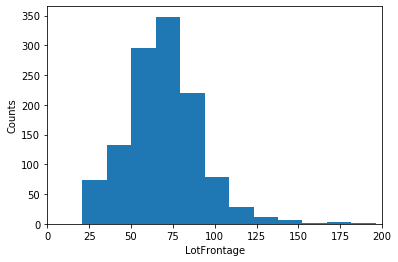

In [16]:
plt.hist(X['LotFrontage'], bins=20)

plt.xlim(0,200)
plt.xlabel('LotFrontage')
plt.ylabel('Counts');

In [17]:
# Test for correlations with 'LotFrontage'
corr = X[list(num_cols)].corr()['LotFrontage']
print(np.abs(corr).sort_values(ascending=False)[:6])

LotFrontage    1.000000
1stFlrSF       0.457181
LotArea        0.426095
GrLivArea      0.402797
TotalBsmtSF    0.392075
MSSubClass     0.386347
Name: LotFrontage, dtype: float64


Do missing values truly mean there is no street connected to the property?  
Unlikely because there are no 'LotFrontage'=0 data points recorded, and the missing 'LotFrontage' houses have typical values for other features. There is no strong correlation between 'LotFrontage' and other features, so I will treat missing values here through simple imputation of the median. Note: I also tried imputation using KNN, but using the median resulted in a better RMSE.

### 2.2.4 Test set: Missing numerical data <a id='section_2.2.4'></a>

In [18]:
print('Missing data in the test set:')
for col in num_cols:
    if X_test[col].isnull().any():
        print(col, sum(X_test[col].isnull()))

Missing data in the test set:
LotFrontage 227
BsmtUnfSF 1
GarageArea 1
BsmtFullBath 2
BsmtHalfBath 2
TotalBsmtSF 1
GarageCars 1
BsmtFinSF1 1
BsmtFinSF2 1


Two houses in the test set are missing data for basement related features because, as indicated by 'BsmtQual', they have no basement. For these houses, I'll change these basement related features from NA to 0.

In [19]:
ind_label = X_test[X_test['BsmtFullBath'].isnull()].index
print(X_test.loc[ind_label][['TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtFullBath','BsmtUnfSF','BsmtHalfBath', 'BsmtQual']])
X_test.loc[ind_label, ['TotalBsmtSF','BsmtFinSF1','BsmtFinSF2','BsmtFullBath','BsmtUnfSF','BsmtHalfBath']] = 0.

      TotalBsmtSF  BsmtFinSF1  BsmtFinSF2  BsmtFullBath  BsmtUnfSF  \
Id                                                                   
2121          NaN         NaN         NaN           NaN        NaN   
2189          0.0         0.0         0.0           NaN        0.0   

      BsmtHalfBath BsmtQual  
Id                           
2121           NaN      NaN  
2189           NaN      NaN  


One house in the test set has no garage as indicated by 'GarageQual' and 'GarageFinish'. I'll change missing numerical values here from NA to 0.

In [20]:
ind_label = X_test[X_test['GarageArea'].isnull()].index
print(X_test.loc[ind_label][['GarageArea','GarageCars','GarageType','GarageFinish','GarageQual']])
X_test.loc[ind_label, ['GarageArea','GarageCars']] = 0.

      GarageArea  GarageCars GarageType GarageFinish GarageQual
Id                                                             
2577         NaN         NaN     Detchd          NaN        NaN


The rest of the missing data in the test set is similar to missing data in the training set and can be handled by the same method in a pipeline later on.

# 3. Exploratory data analysis <a id='section_3'></a>

[3.1 Distribution of the target variable](#section_3.1)  

[3.2 Univariate analysis of features](#section_3.2)  
- [3.2.1 Numerical features](#section_3.2.1)  
- [3.2.2 Ordinal features](#section_3.2.2)    
- [3.2.3 Nominal features](#section_3.2.3)    

[3.3 Multivariate analysis](#section_3.3)
- [3.3.1 Feature - Target Correlation: numerical, ordinal](#section_3.3.1)  
- [3.3.2 Feature - Target "Correlation": nominal](#section_3.3.2)  


Useful reference: https://elitedatascience.com/exploratory-analysis

## 3.1 EDA: Distribution of the target variable <a id='section_3.1'></a>

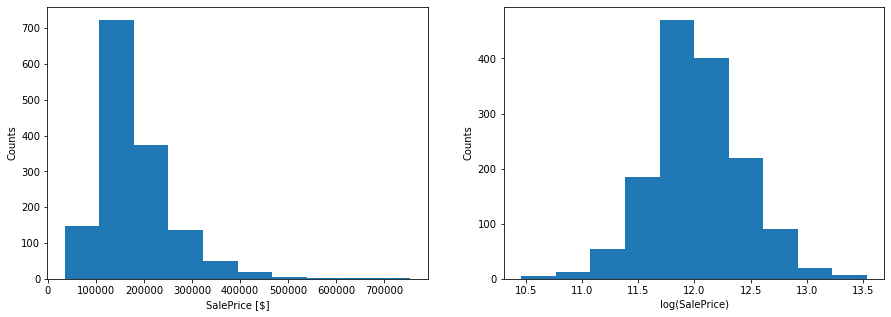

In [21]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(np.expm1(y))
plt.xlabel('SalePrice [$]')
plt.ylabel('Counts')

plt.subplot(1,2,2)
plt.hist(y)
plt.xlabel('log(SalePrice)')
plt.ylabel('Counts');

In [22]:
print('Skew of SalePrice:', np.round(np.expm1(y).skew(), decimals=2))
print('Skew of log(SalePrice):', np.round(y.skew(), decimals=2))

Skew of SalePrice: 1.88
Skew of log(SalePrice): 0.12


The evaluation metric for this problem is stated to be the RMSE between the log of the observed SalePrice values and the log of the predicted SalePrice values. Thus, it makes sense to log transform the target variable. Additionally, a log transform ensures the target variable is normally distributed.

## 3.2 EDA: Univariate analysis of features <a id='section_3.2'></a>
Here I'll use histograms to take a look at the distributions of individual features.

### 3.2.1 EDA: Univariate Analysis: Numerical features  <a id='section_3.2.1'></a>

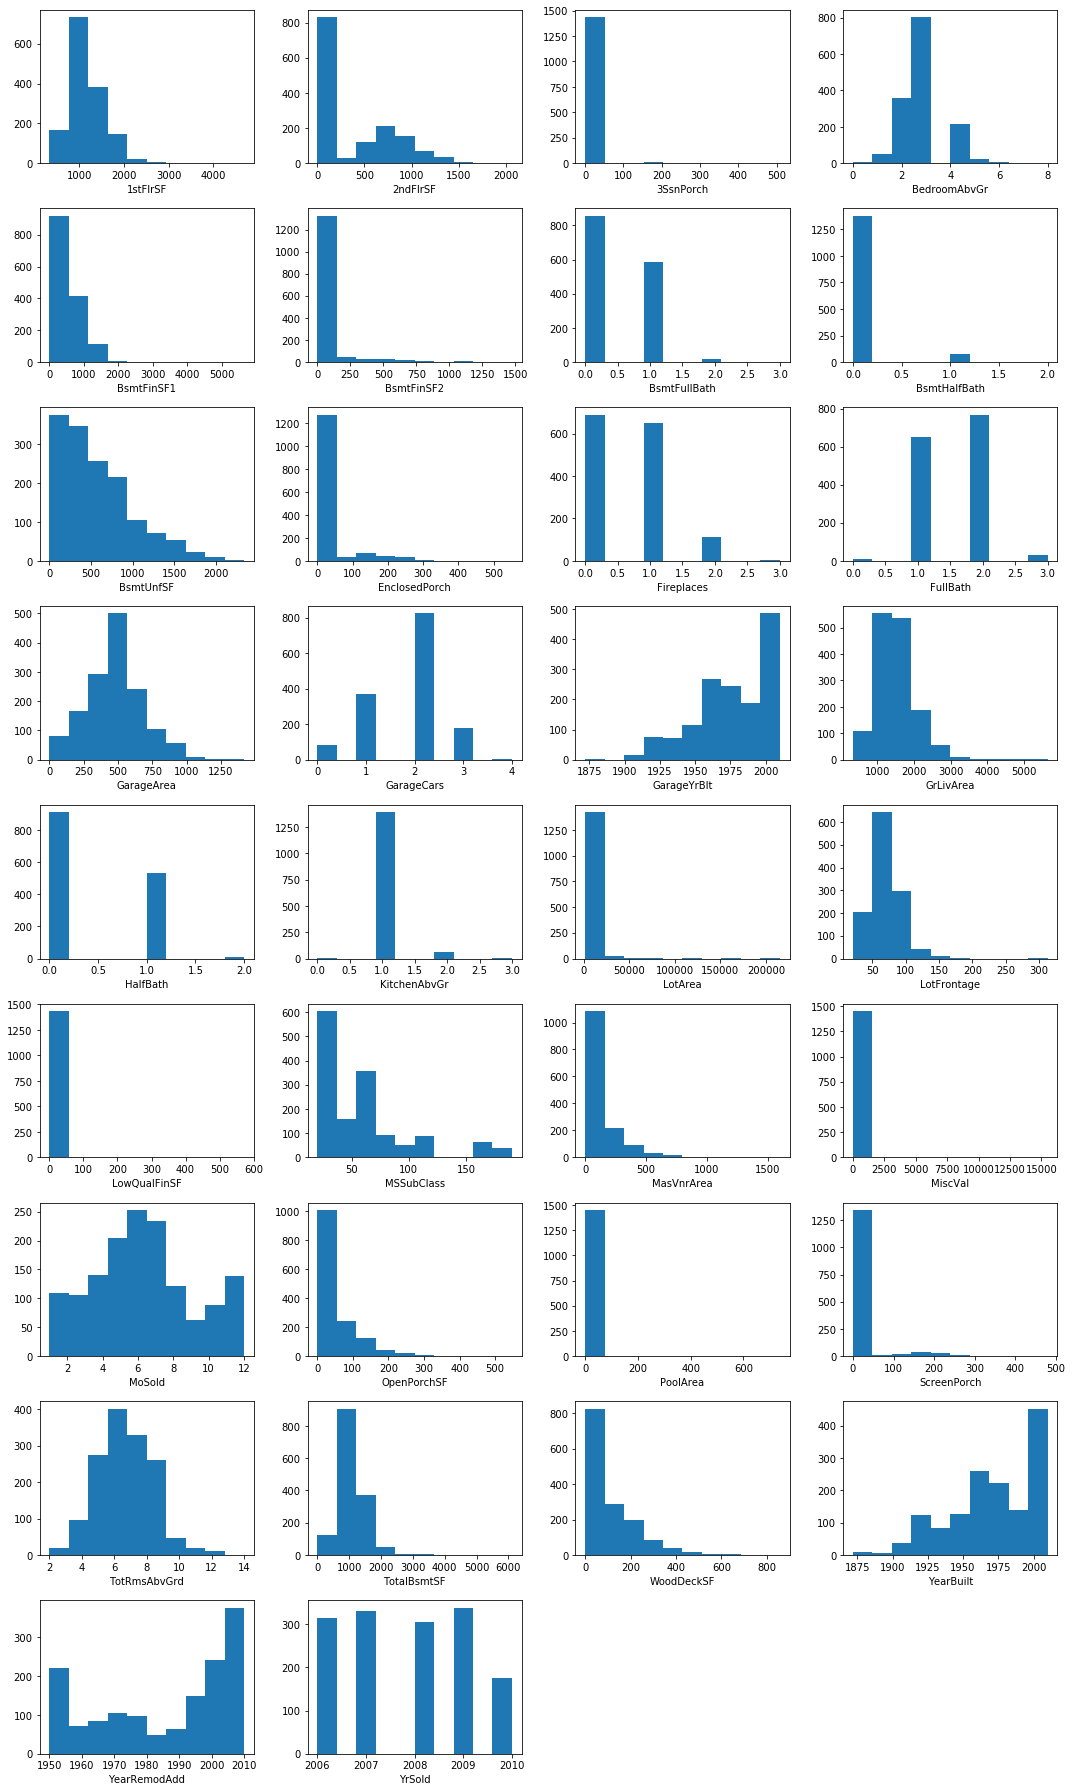

In [23]:
# Histogram grid of all numerical features

num_cols.sort() # alphabetize feature names

fig = plt.figure(figsize=(15, 25)) # (width,height)
for index, col in enumerate(num_cols):
    ax = fig.add_subplot(np.ceil(len(num_cols)/4), 4, index+1)
    plt.hist(X[col].dropna())
    plt.xlabel(col)
plt.tight_layout()

Notes on distributions of numerical features:
- some distributions are skewed, especially for features related to area - e.g., '1stFlrSF', 'BsmtFinSF1'
- some distributions are sparse, especially for features related to deck and porch area - e.g., 'ScreenPorch', '3SsnPorch'
- outliers are particularly visible in 'GrLivArea'

### 3.2.2 EDA: Univariate Analysis: Ordinal Features <a id='section_3.2.2'></a>

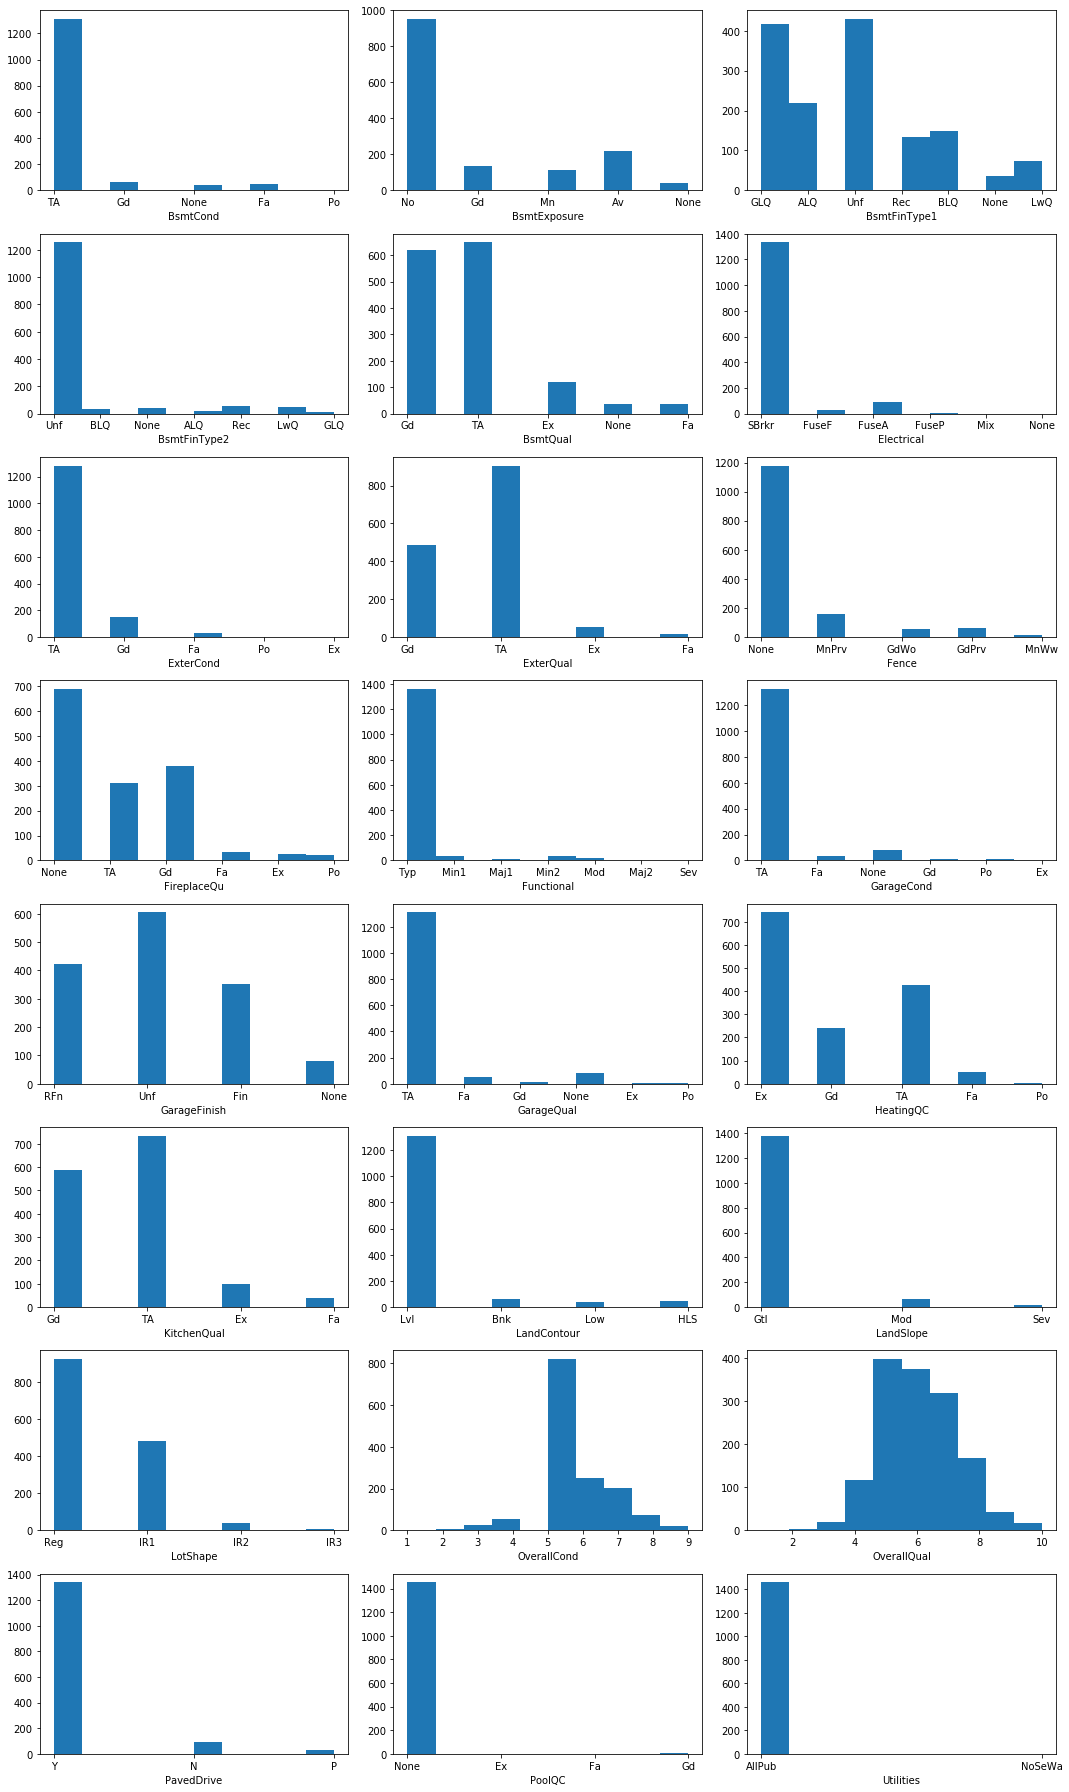

In [24]:
# Histogram grid of all categorical - ordinal features

catord_cols.sort() # alphabetize feature names

fig = plt.figure(figsize=(15, 25)) # (width,height)
for index, col in enumerate(catord_cols):
    ax = fig.add_subplot(np.ceil(len(catord_cols)/3), 3, index+1)
    plt.hist(X[col].fillna(value='None'))
    plt.xlabel(col)
plt.tight_layout()

Notes on ordinal features:
- a substantial fraction of ordinal features have nearly all of the data in one primary class - e.g.,  most houses have a typical garage ('GarageCond'), a typical home functionality ('Functional'), and no pool ('PoolQC'). These would be good features to bin.

### 3.2.3 EDA: Univariate Analysis: Nominal Features <a id='section_3.2.3'></a>

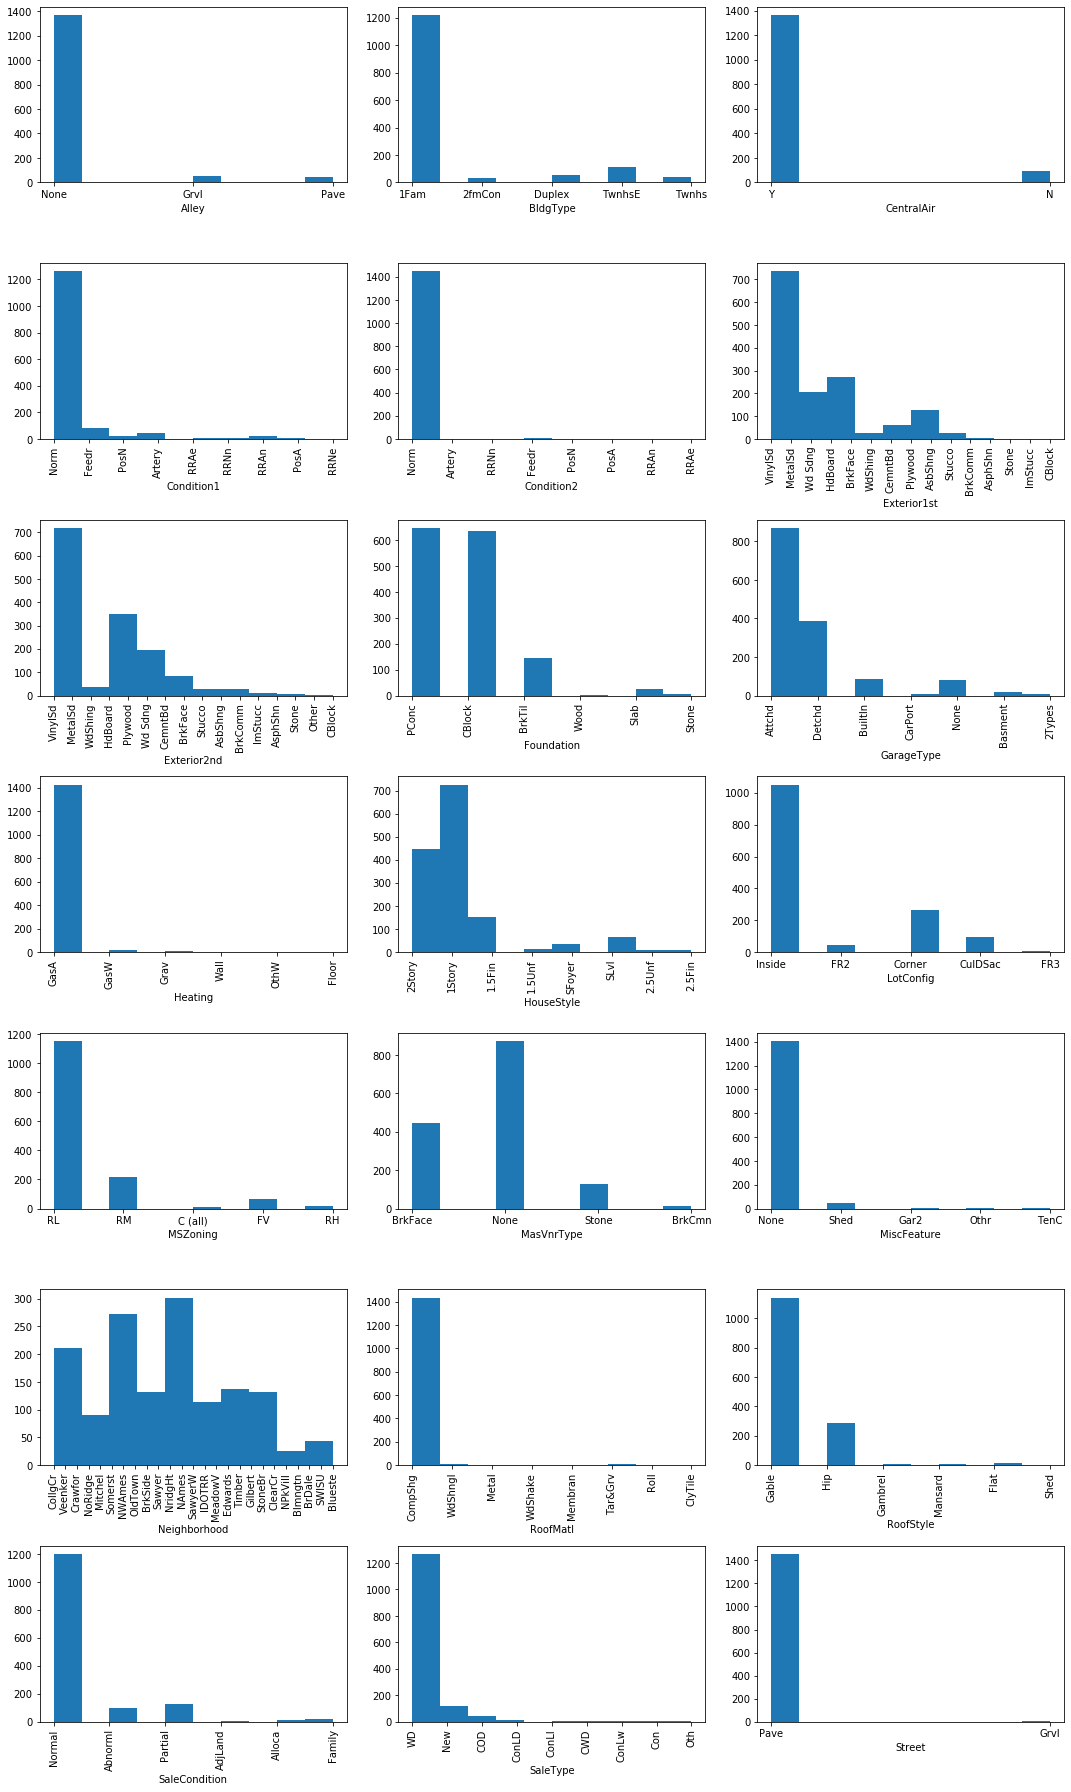

In [25]:
# Histogram grid of all categorical - nominal features

catnom_cols.sort() # alphabetize feature names

fig = plt.figure(figsize=(15, 25)) # (width,height)
for index, col in enumerate(catnom_cols):
    ax = fig.add_subplot(np.ceil(len(catnom_cols)/3), 3, index+1)
    plt.hist(X[col].fillna(value='None'))
    plt.xlabel(col)
    if len(X[col].unique())>5:
        plt.xticks(rotation=90)
plt.tight_layout()

Notes on nominal features:
- most houses in this dataset are 1 family homes ('BldgType') with 1 or 2 stories ('HouseStyle') in low-density residential areas ('MSZoning')
- there are some higher cardinality nominal features like 'Neighborhood', 'Exterior1st', 'Exterior2nd'

## 3.3 EDA: Multivariate analysis <a id='section_3.3'></a>
Here I identify which features are most strongly correlated to the target variable.

In [26]:
# Label encoding the ordinal data for the correlation analysis
X_enc = CustomOrdinalEncoder().transform(X)

### 3.3.1 Feature (numerical, ordinal) - Target Correlation <a id='section_3.3.1'></a>

In [27]:
# Features with greatest correlation to target

# Calculate pearson correlation between target and numeric and ordinal features
corr = X_enc[num_cols+catord_cols].corrwith(y)
print(corr.sort_values(ascending=False)[:10])
print(corr.sort_values(ascending=False)[-3:])

# List of features most strongly correlated with target
corr_top = list(np.abs(corr).sort_values(ascending=False)[:8].keys())

OverallQual     0.817185
GrLivArea       0.700927
GarageCars      0.680625
ExterQual       0.678840
KitchenQual     0.667893
GarageArea      0.650888
BsmtQual        0.615804
TotalBsmtSF     0.612134
GarageFinish    0.604878
1stFlrSF        0.596981
dtype: float64
Fence           -0.145725
KitchenAbvGr    -0.147548
EnclosedPorch   -0.149050
dtype: float64


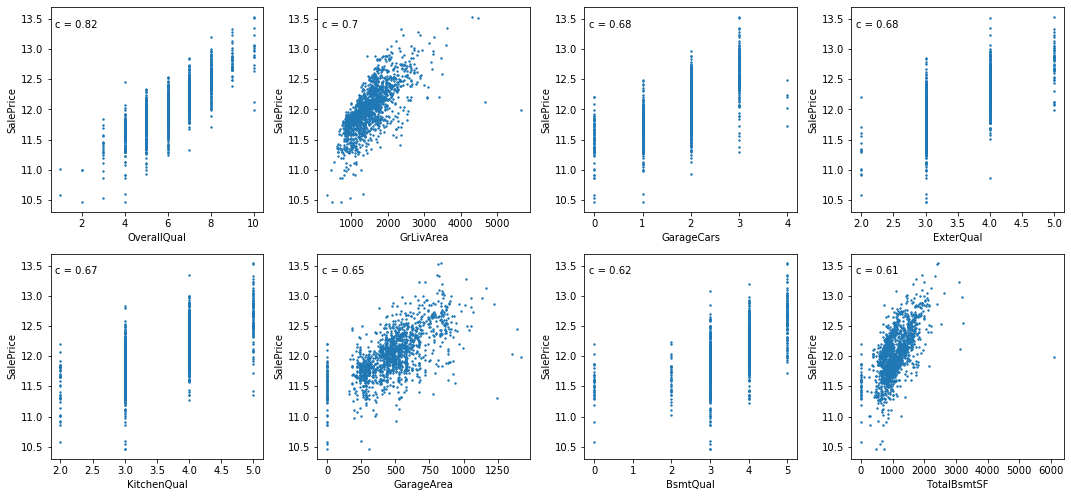

In [28]:
# Scatter plots for the features most highly correlated with the target variable

fig = plt.figure(figsize=(15, 10)) # (width,height)
for index, col in enumerate(corr_top):
    ax = fig.add_subplot(3, 4, index+1)
    plt.scatter(X_enc[col], y, s=2)
    c = np.round(X_enc[col].corr(y),decimals=2) # correlation with target for feature
    plt.annotate('c = '+str(c), (0.02,0.9), xycoords='axes fraction')
    plt.xlabel(col)
    plt.ylabel('SalePrice')
plt.tight_layout()

The features with the greatest correlation to 'SalePrice' are those features related to the quality of the house ('OverallQual', 'ExterQual', 'KitchenQual', 'BsmtQual') and those related to the area of the house ('GrLivArea', 'GarageCars', 'GarageArea', 'TotalBsmtSF'). 

### 3.3.2 Feature (nominal) - Target "Correlation" <a id='section_3.3.2'></a>
Very useful resource: [An overview of correlation measures between categorical and continuous variables](https://medium.com/@outside2SDs/an-overview-of-correlation-measures-between-categorical-and-continuous-variables-4c7f85610365)

In [29]:
# Kruskal-Wallis H-test
from scipy import stats

df_kruskal = pd.DataFrame(columns=['col','f','p'])
for index, col in enumerate(catnom_cols):
    f, p = stats.kruskal(*[y.loc[X[X[col]==x].index] for x in set(X[col])])
    df_kruskal = df_kruskal.append({'col': col , 'f': f, 'p': p} , ignore_index=True)
df_kruskal = df_kruskal.sort_values(by='f', ascending=False)
df_kruskal.head()

,col,f,p
15,Neighborhood,868.532376,6.696799e-168
7,Foundation,488.722751,2.169096e-103
5,Exterior1st,304.044576,1.694486e-56
6,Exterior2nd,284.231143,1.047636e-51
12,MSZoning,270.070197,3.080724e-57


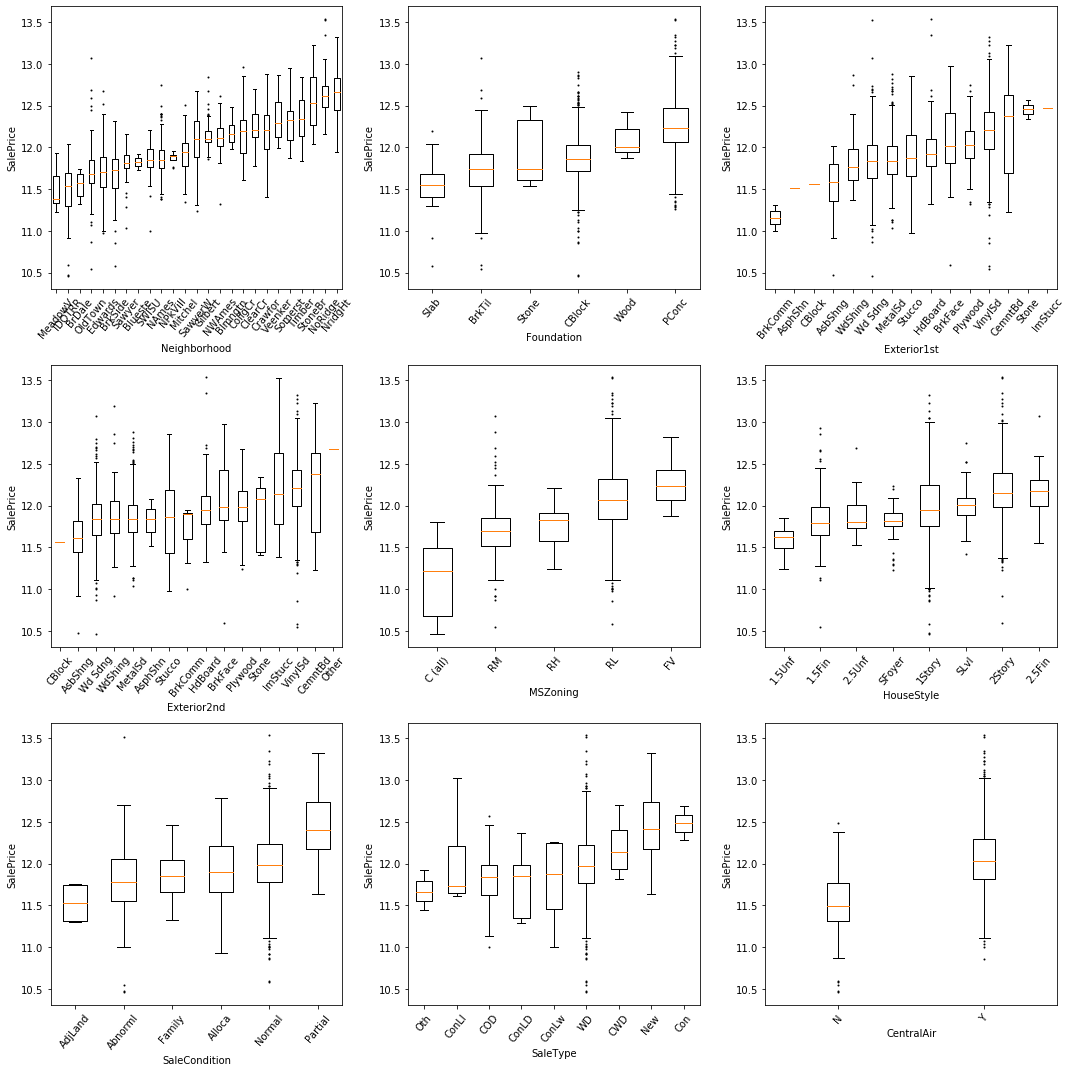

In [30]:
# Boxplots for those features with highest kruskal score

fig = plt.figure(figsize=(15, 15)) # (width,height)

outlier_marker = dict(markerfacecolor='k', marker='.', markersize=2)

for index, col in enumerate(df_kruskal['col'][:9]):
    ax = fig.add_subplot(3, 3, index+1)

    data = []
    x_vals =X[col].unique()
    med_list = []
    for x in x_vals:
        yy = y[X[col]==x].dropna(axis=0).values
        data.append(yy)
        med_list.append(np.median(yy))
        
    df_plot = pd.DataFrame({'x_vals': x_vals, 'median': med_list, 'data': data})
    df_plot = df_plot.sort_values(by='median')
    
    plt.boxplot(df_plot['data'], flierprops=outlier_marker)
    
    locs=ax.get_xticks()
    plt.xticks(locs, df_plot['x_vals'], rotation=50)

    plt.xlabel(col)
    plt.ylabel('SalePrice')
plt.tight_layout()

Based on the Kruskal-Wallis test, nominal features likely to be important for predicting 'SalePrice' include the location of the house ('Neighborhood', 'MSZoning'), as well as the style of house and garage ('HouseStyle', 'GarageType'). 

Additionally important features include those dealing with the type of materials used for the foundation ('Foundation') and exterior ('Exterior1st','Exterior2nd'), and the condition and type of house sale ('SaleCondition', 'SaleType').

# 4. Feature Engineering <a id='section_4'></a>
[4.1 Summing existing features](#section_4.1)  
[4.2 Binning features](#section_4.2)  
[4.3 Grouping some nominal features with SalePrice](#section_4.3)  
[4.4 Other new features](#section_4.4)  
[4.5 Polynomial features](#section_4.5)  
[4.6 Summary of new features](#section_4.6)  

Useful references:  
https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114  
https://towardsdatascience.com/understanding-feature-engineering-part-1-continuous-numeric-data-da4e47099a7b

For the purpose of creating new features, I combine the training and testing data sets. I'll separate them afterwards, and perform final imputation and nominal encoding in the cross-validation analysis to prevent data leakage.

In [31]:
# Performing label encoding on the ordinal features
X_enc = pd.concat([CustomOrdinalEncoder().transform(X),y], axis=1) # adding SalePrice as reference for feature engineering
X_test_enc = CustomOrdinalEncoder().transform(X_test)

# Combining train and test data sets
X_all = pd.concat([X_enc, X_test_enc], axis=0, sort=True)

## 4.1 Summing existing features <a id='section_4.1'></a>
Combining existing features to produce total quantities of area, room numbers, quality, and condition.

Correlation with target: 0.39838691514943175
TotalDeckPorchArea    1.000000
WoodDeckSF            0.740180
OpenPorchSF           0.444038
SalePrice             0.398387
GrLivArea             0.375455
Name: TotalDeckPorchArea, dtype: float64


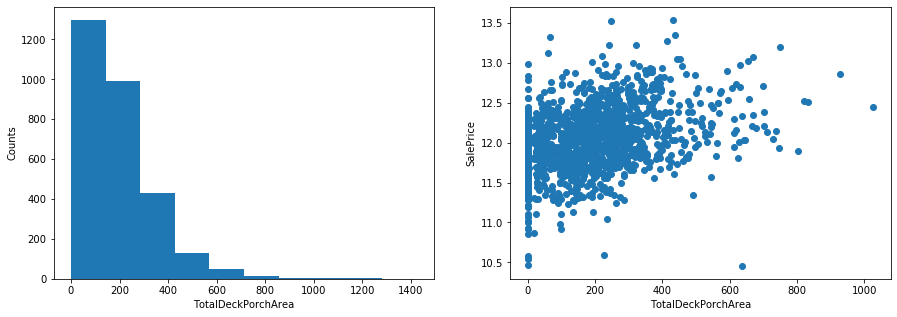

In [32]:
# Total Deck+Porch Area

X_all['TotalDeckPorchArea'] = X_all['WoodDeckSF']+X_all['OpenPorchSF']+X_all['EnclosedPorch']+\
                              X_all['3SsnPorch']+X_all['ScreenPorch']

print('Correlation with target:', X_all['TotalDeckPorchArea'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['TotalDeckPorchArea']).sort_values(ascending=False)[:5])

fig = plt.figure(figsize=(15, 5)) # (width,height)    
plt.subplot(1,2,1)
plt.hist(X_all['TotalDeckPorchArea'])
plt.xlabel('TotalDeckPorchArea')
plt.ylabel('Counts')

plt.subplot(1,2,2)
plt.scatter(X_all['TotalDeckPorchArea'], X_all['SalePrice'])
plt.xlabel('TotalDeckPorchArea')
plt.ylabel('SalePrice');

Correlation with target: 0.812363890368827
TotalHouseArea    1.000000
GrLivArea         0.850612
SalePrice         0.812364
TotalBsmtSF       0.801289
1stFlrSF          0.776389
Name: TotalHouseArea, dtype: float64


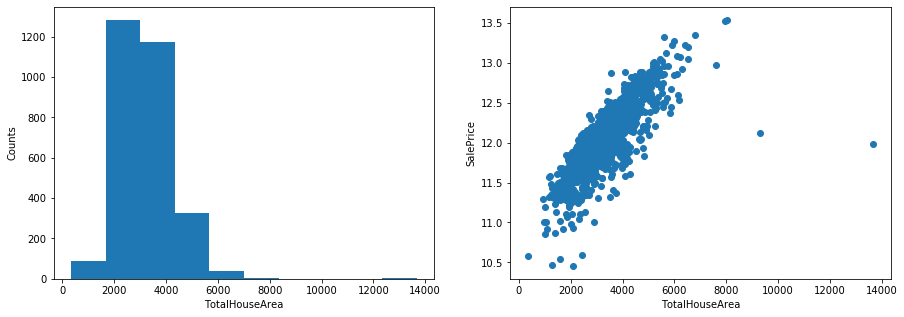

In [33]:
# Total house area

X_all['TotalHouseArea'] = X_all['TotalBsmtSF']+X_all['GrLivArea']+X_all['GarageArea']+ \
                          X_all['WoodDeckSF']+X_all['OpenPorchSF']+X_all['EnclosedPorch']+\
                          X_all['3SsnPorch']+X_all['ScreenPorch']
        
print('Correlation with target:', X_all['TotalHouseArea'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['TotalHouseArea']).sort_values(ascending=False)[:5])

fig = plt.figure(figsize=(15, 5)) # (width,height)    
plt.subplot(1,2,1)
plt.hist(X_all['TotalHouseArea'])
plt.xlabel('TotalHouseArea')
plt.ylabel('Counts')

plt.subplot(1,2,2)
plt.scatter(X_all['TotalHouseArea'], X_all['SalePrice'])
plt.xlabel('TotalHouseArea')
plt.ylabel('SalePrice');

# Note: 'GrLivArea' = '1stFlrSF' + '2ndFlrSF' + 'LowQualFinSF'

In [34]:
# Number of bathrooms

# BsmtFullBath: Basement full bathrooms - from data description
# BsmtHalfBath: Basement half bathrooms
# FullBath: Full bathrooms above grade
# HalfBath: Half baths above grade

X_all['TotalBath'] = X_all['BsmtFullBath']+X_all['BsmtHalfBath']+X_all['FullBath']+X_all['HalfBath']
print('Correlation with target:', X_all['TotalBath'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['TotalBath']).sort_values(ascending=False)[:4])
print()

X_all['BsmtBath'] = X_all['BsmtFullBath']+X_all['BsmtHalfBath']
print('Correlation with target:', X_all['BsmtBath'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['BsmtBath']).sort_values(ascending=False)[:4])
print()

X_all['TotalGroundBath'] = X_all['FullBath']+X_all['HalfBath']
print('Correlation with target:', X_all['TotalGroundBath'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['TotalGroundBath']).sort_values(ascending=False)[:4])

Correlation with target: 0.6577983349388128
TotalBath    1.000000
SalePrice    0.657798
FullBath     0.648372
GrLivArea    0.622793
Name: TotalBath, dtype: float64

Correlation with target: 0.22548439554003324
BsmtBath        1.000000
BsmtFullBath    0.895309
BsmtFinSF1      0.650288
BsmtFinType1    0.600573
Name: BsmtBath, dtype: float64

Correlation with target: 0.6108010825655603
TotalGroundBath    1.000000
TotalBath          0.816424
FullBath           0.786640
HalfBath           0.734212
Name: TotalGroundBath, dtype: float64


Correlation with target: 0.663901151358804
TotalRooms         1.000000
TotRmsAbvGrd       0.922593
GrLivArea          0.855069
TotalGroundBath    0.773049
Name: TotalRooms, dtype: float64


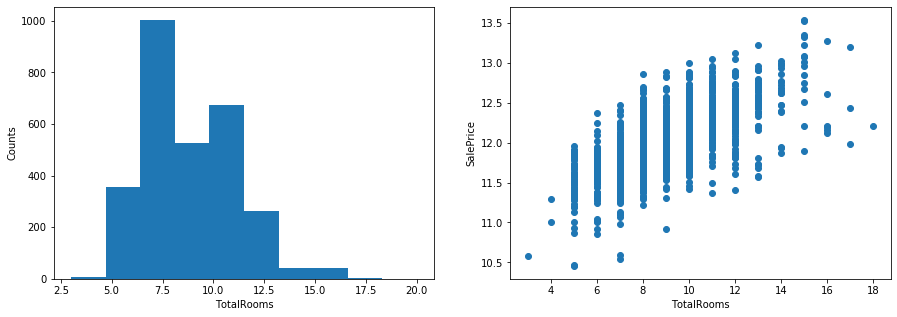

In [35]:
# Total number of rooms

X_all['TotalRooms'] = X_all['TotRmsAbvGrd']+X_all['FullBath']+X_all['HalfBath']+\
                      X_all['BsmtFullBath']+X_all['BsmtHalfBath']
    
print('Correlation with target:', X_all['TotalRooms'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['TotalRooms']).sort_values(ascending=False)[:4])

fig = plt.figure(figsize=(15, 5)) # (width,height)    
plt.subplot(1,2,1)
plt.hist(X_all['TotalRooms'])
plt.xlabel('TotalRooms')
plt.ylabel('Counts')

plt.subplot(1,2,2)
plt.scatter(X_all['TotalRooms'], X_all['SalePrice'])
plt.xlabel('TotalRooms')
plt.ylabel('SalePrice');

Correlation with target: 0.8434034151092041
SRSSQual       1.000000
OverallQual    0.969539
SalePrice      0.843403
ExterQual      0.814859
Name: SRSSQual, dtype: float64


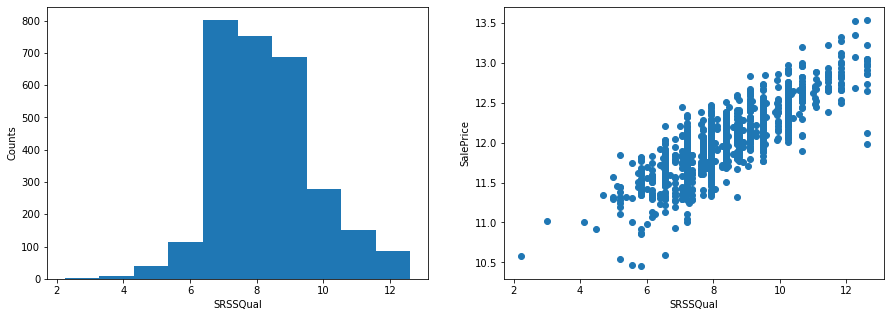

In [36]:
# Average Quality

SRSSQual = (X_all['OverallQual']**2.+X_all['ExterQual']**2.+X_all['BsmtQual']**2.+X_all['GarageQual']**2.)**0.5

X_all['SRSSQual'] = SRSSQual
print('Correlation with target:', X_all['SRSSQual'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['SRSSQual']).sort_values(ascending=False)[:4])

fig = plt.figure(figsize=(15, 5)) # (width,height)    
plt.subplot(1,2,1)
plt.hist(X_all['SRSSQual'])
plt.xlabel('SRSSQual')
plt.ylabel('Counts')

plt.subplot(1,2,2)
plt.scatter(X_all['SRSSQual'], X_all['SalePrice'])
plt.xlabel('SRSSQual')
plt.ylabel('SalePrice');

Correlation with target: 0.2258097181829378
SumCond        1.000000
OverallCond    0.784886
ExterCond      0.554442
GarageCond     0.514228
Name: SumCond, dtype: float64


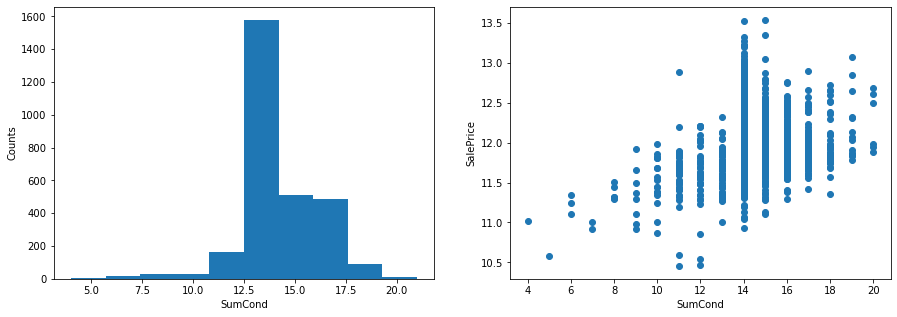

In [37]:
# Summed Condition

SumCond = (X_all['OverallCond']+X_all['ExterCond']+X_all['BsmtCond']+X_all['GarageCond'])
   
X_all['SumCond'] = SumCond
print('Correlation with target:', X_all['SumCond'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['SumCond']).sort_values(ascending=False)[:4])

fig = plt.figure(figsize=(15, 5)) # (width,height)    
plt.subplot(1,2,1)
plt.hist(X_all['SumCond'])
plt.xlabel('SumCond')
plt.ylabel('Counts')

plt.subplot(1,2,2)
plt.scatter(X_all['SumCond'], X_all['SalePrice'])
plt.xlabel('SumCond')
plt.ylabel('SalePrice');

## 4.2 Feature Binning <a id='section_4.2'></a>

### Feature binning: Numerical features with significant fractions of value=0 elements

In [38]:
# Binning some numerical columns into zero and non-zero categories
for col in ['WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'Fireplaces']:
    ind_zero = X_all[X_all[col]==0].index.tolist() 
    ind_nonzero = X_all[X_all[col]!=0].index.tolist() 
    print(col, 'Fraction of 0 values:', np.round(len(ind_zero)/len(X_all),decimals=2))
        
    X_all[str(col)+'_Bin'] = X_all[str(col)].copy()
    X_all.loc[ind_zero, str(col)+'_Bin'] = 0 #'zero'
    X_all.loc[ind_nonzero, str(col)+'_Bin'] = 1 #'nonzero'

WoodDeckSF Fraction of 0 values: 0.52
OpenPorchSF Fraction of 0 values: 0.44
EnclosedPorch Fraction of 0 values: 0.84
3SsnPorch Fraction of 0 values: 0.99
ScreenPorch Fraction of 0 values: 0.91
Fireplaces Fraction of 0 values: 0.49


### Feature binning: Categorical (ordinal+nominal) features with low frequency values

In [39]:
# Binning some nominal features into primary | other categories

limit=0.80 # binning features if 80% of values are in a single category

for col in catnom_cols:
    
    vals = X_all[col].unique()
    val_counts = X_all[col].value_counts()
    if (len(vals)>2) and (max(val_counts)/len(X_all))>limit:
        print(col, np.round((max(val_counts)/len(X_all)),decimals=2))
        
        primary = list(val_counts[val_counts.values==max(val_counts.values)].keys())
        other = list(set(vals)-set(primary))
        
        X_all[str(col)+'_Bin'] = X_all[str(col)].copy().replace(to_replace=other, value='other')

BldgType 0.83
Condition1 0.86
Condition2 0.99
Heating 0.98
RoofMatl 0.99
SaleCondition 0.82
SaleType 0.87


In [40]:
# Binning some ordinal features into primary | other categories

limit=0.80 # binning features if 80% of values are in a single category

for col in catord_cols:
    
    vals = X_all[col].unique()
    val_counts = X_all[col].value_counts()
    if (len(vals)>2) and (max(val_counts)/len(X_all))>limit:
        print(col, np.round((max(val_counts)/len(X_all)),decimals=2))
        
        primary = list(val_counts[val_counts.values==max(val_counts.values)].keys())
        other = list(set(vals)-set(primary))
        
        X_all[str(col)+'_Bin'] = X_all[str(col)].copy().replace(to_replace=primary, value=1)
        X_all[str(col)+'_Bin'] = X_all[str(col)].copy().replace(to_replace=other, value=0)

BsmtCond 0.89
BsmtFinType2 0.85
Electrical 0.92
ExterCond 0.87
Fence 0.8
Functional 0.93
GarageCond 0.91
GarageQual 0.89
LandContour 0.9
LandSlope 0.95
PavedDrive 0.9
PoolQC 1.0
Utilities 1.0


In [41]:
# Season Sold
X_all['SeasonSold'] = X_all['MoSold'].copy().replace(
    {12: 1, 1: 1, 2: 1, # 12-2: winter
     3: 2, 4: 2, 5: 2, # 3-5: spring
     6: 3, 7: 3, 8: 3, # 6-8: summer
     9: 4, 10: 4, 11: 4 # 9-11: fall
    })

## 4.3 Grouping nominal features according to SalePrice <a id='section_4.3'></a>
Binning nominal features according to their relationship with the target variable

#### Feature binning: Neighborhood and SalePrice

In [42]:
# Sort neighborhoods by median SalePrice value:
df = X_all.groupby(['Neighborhood']).median()[['SalePrice','OverallQual']].sort_values(by='SalePrice')

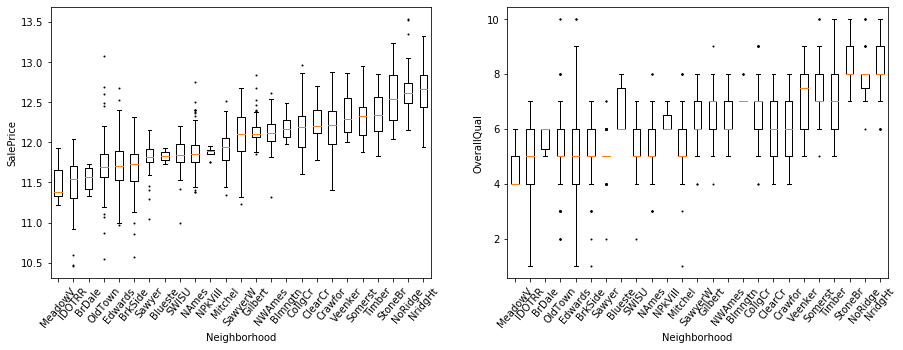

In [43]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

outlier_marker = dict(markerfacecolor='k', marker='.', markersize=2)

# Plotting Neighborhood and median SalePrice
ax = fig.add_subplot(1, 2, 1)    
data = []
for x in df.index:
        yy = X_all['SalePrice'][X_all['Neighborhood']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, df.index, rotation=50)

plt.xlabel('Neighborhood')
plt.ylabel('SalePrice')


# Plotting Neighborhood and median OverallQual
ax = fig.add_subplot(1, 2, 2)    
data = []
for x in df.index:
        yy = X_all['OverallQual'][X_all['Neighborhood']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, df.index, rotation=50)

plt.xlabel('Neighborhood')
plt.ylabel('OverallQual');

In [44]:
# Divide into low, medium, and high price bins

div = np.array_split(range(len(df.index)), 3)
df['rank'] = [1 for x in df.index[div[0]]] + \
             [2 for x in df.index[div[1]]] + \
             [3 for x in df.index[div[2]]]     
dct = dict(zip(df.index, df['rank']))

X_all['Neighborhood_Price'] = X_all['Neighborhood'].copy().replace(dct).apply(pd.to_numeric)

Correlation with target: 0.6703655546000804
Neighborhood_Price    1.000000
SalePrice             0.670366
SRSSQual              0.650660
OverallQual           0.611157
YearBuilt             0.608934
Name: Neighborhood_Price, dtype: float64


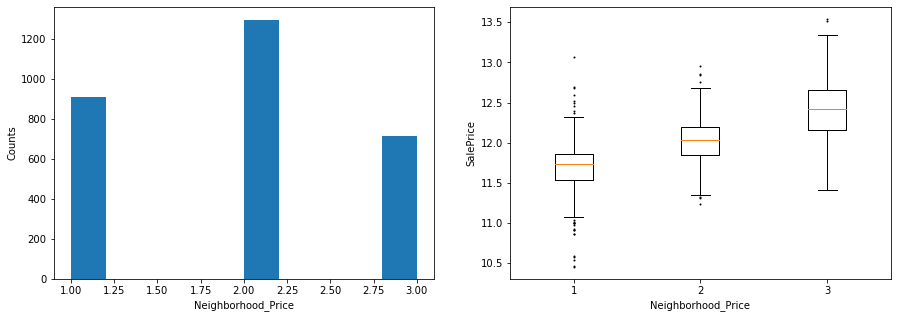

In [45]:
# Plotting distribution of new feature

fig = plt.figure(figsize=(15, 5)) # (width,height)

plt.subplot(1,2,1)
plt.hist(X_all['Neighborhood_Price'])
plt.xlabel('Neighborhood_Price')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
data = []
x_vals = [1,2,3]
for x in x_vals:
        yy = X_all['SalePrice'][X_all['Neighborhood_Price']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, x_vals)

plt.xlabel('Neighborhood_Price')
plt.ylabel('SalePrice');

print('Correlation with target:', X_all['Neighborhood_Price'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['Neighborhood_Price']).sort_values(ascending=False)[:5]);

#### Feature binning: Exterior1st, Exterior2nd and SalePrice

In [46]:
# Combine exterior columns and compute median

ext_list = list(set(list(X_all['Exterior1st'].unique())+list(X_all['Exterior2nd'].unique())))

X_exterior = pd.DataFrame()
X_exterior['Exterior'] = pd.concat([X_all['Exterior1st'], X_all['Exterior2nd']], axis=0)
X_exterior['SalePrice'] = pd.concat([X_all['SalePrice'], X_all['SalePrice']], axis=0)

df = X_exterior.groupby(['Exterior']).median()[['SalePrice']].sort_values(by='SalePrice')

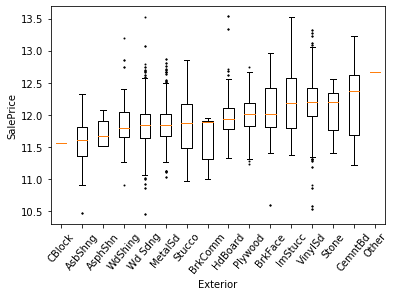

In [47]:
# Exterior and median SalePrice

ax = plt.subplot()
data = []
for x in df.index:
        yy1 = X_all['SalePrice'][X_all['Exterior1st']==x].dropna(axis=0).values
        yy2 = X_all['SalePrice'][X_all['Exterior2nd']==x].dropna(axis=0).values
        data.append(list(yy1)+list(yy2))
        
outlier_marker = dict(markerfacecolor='k', marker='.', markersize=2)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, df.index, rotation=50)

plt.xlabel('Exterior')
plt.ylabel('SalePrice');

In [48]:
# Divide into low, medium, and high price bins

div = np.array_split(range(len(df.index)), 3)
df['rank'] = [1 for x in df.index[div[0]]] + \
             [2 for x in df.index[div[1]]] + \
             [3 for x in df.index[div[2]]]     
dct = dict(zip(df.index, df['rank']))

X_all['Exterior1st_Price'] = X_all['Exterior1st'].copy().replace(dct).apply(pd.to_numeric)
X_all['Exterior2nd_Price'] = X_all['Exterior2nd'].copy().replace(dct).apply(pd.to_numeric)

Correlation with target: 0.39726311368753986
Exterior1st_Price    1.000000
Exterior2nd_Price    0.944311
YearBuilt            0.616953
GarageYrBlt          0.576493
YearRemodAdd         0.520269
Name: Exterior1st_Price, dtype: float64

Correlation with target: 0.3907698934634786
Exterior2nd_Price    1.000000
Exterior1st_Price    0.944311
YearBuilt            0.598086
GarageYrBlt          0.563268
YearRemodAdd         0.512857
Name: Exterior2nd_Price, dtype: float64


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


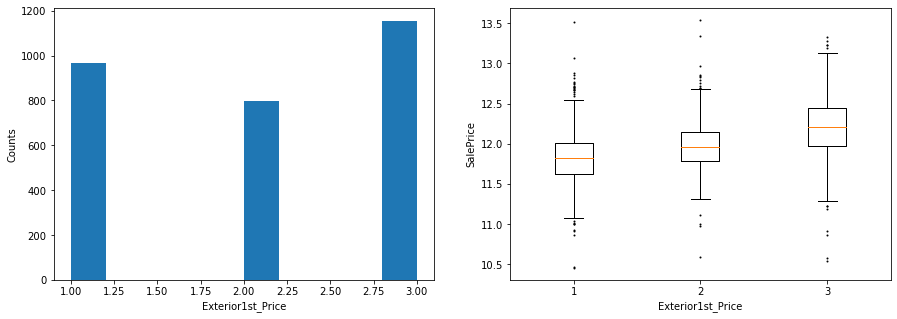

In [49]:
# Plotting distribution of new feature

print('Correlation with target:', X_all['Exterior1st_Price'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['Exterior1st_Price']).sort_values(ascending=False)[:5])
print()

print('Correlation with target:', X_all['Exterior2nd_Price'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['Exterior2nd_Price']).sort_values(ascending=False)[:5])

fig = plt.figure(figsize=(15, 5)) # (width,height)

ax = plt.subplot(1,2,1)
plt.hist(X_all['Exterior1st_Price'])
plt.xlabel('Exterior1st_Price')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
data = []
x_vals = [1,2,3]
for x in x_vals:
        yy = X_all['SalePrice'][X_all['Exterior1st_Price']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, x_vals)

plt.xlabel('Exterior1st_Price')
plt.ylabel('SalePrice');

#### Feature binning: Foundation and SalePrice

In [50]:
# Sort Foundation by median SalePrice value:
df = X_all.groupby(['Foundation']).median()[['SalePrice']].sort_values(by='SalePrice')

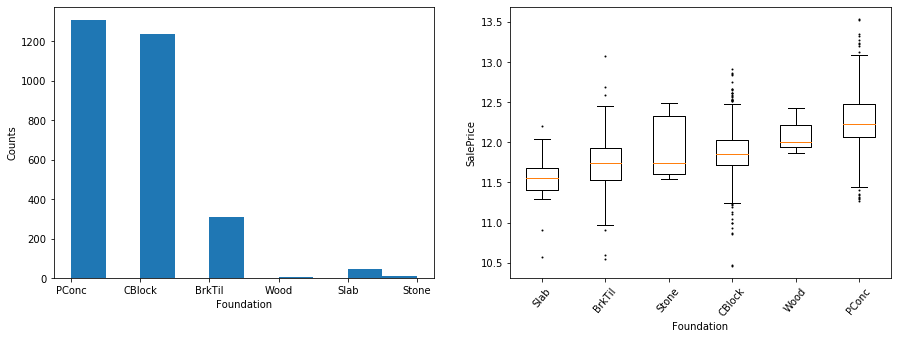

In [51]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

ax = plt.subplot(1,2,1)
plt.hist(X_all['Foundation'])
plt.xlabel('Foundation')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
data = []
for x in df.index:
        yy = X_all['SalePrice'][X_all['Foundation']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, df.index, rotation=50)

plt.xlabel('Foundation')
plt.ylabel('SalePrice');


In [52]:
# Divide into low, medium, and high price bins
div = np.array_split(range(len(df.index)), 3)
df['rank'] = [1 for x in df.index[div[0]]] + \
             [2 for x in df.index[div[1]]] + \
             [3 for x in df.index[div[2]]]     
dct = dict(zip(df.index, df['rank']))

X_all['Foundation_Price'] = X_all['Foundation'].copy().replace(dct).apply(pd.to_numeric)

Correlation with target: 0.5342944191174634
Foundation_Price    1.000000
YearBuilt           0.737367
GarageYrBlt         0.667762
SRSSQual            0.602809
BsmtQual            0.600496
Name: Foundation_Price, dtype: float64


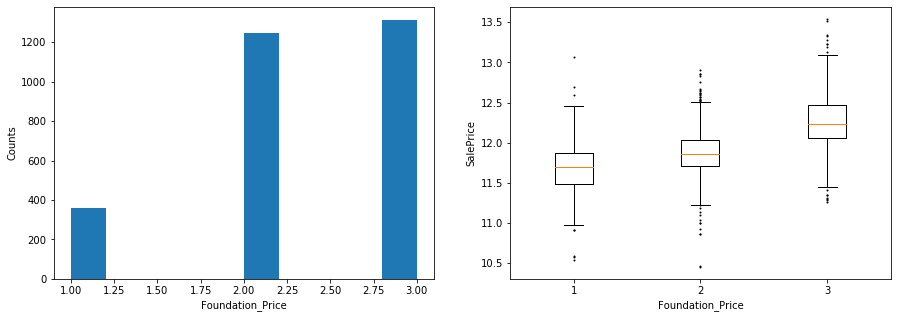

In [53]:
print('Correlation with target:', X_all['Foundation_Price'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['Foundation_Price']).sort_values(ascending=False)[:5])

# Plotting distribution of new feature

fig = plt.figure(figsize=(15, 5)) # (width,height)

ax = plt.subplot(1,2,1)
plt.hist(X_all['Foundation_Price'])
plt.xlabel('Foundation_Price')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
data = []
x_vals = [1,2,3]
for x in x_vals:
        yy = X_all['SalePrice'][X_all['Foundation_Price']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, x_vals)

plt.xlabel('Foundation_Price')
plt.ylabel('SalePrice');

#### Feature binning: HouseStyle and SalePrice

In [54]:
# Sort HouseStyle by median SalePrice value:
df = X_all.groupby(['HouseStyle']).median()[['SalePrice']].sort_values(by='SalePrice')

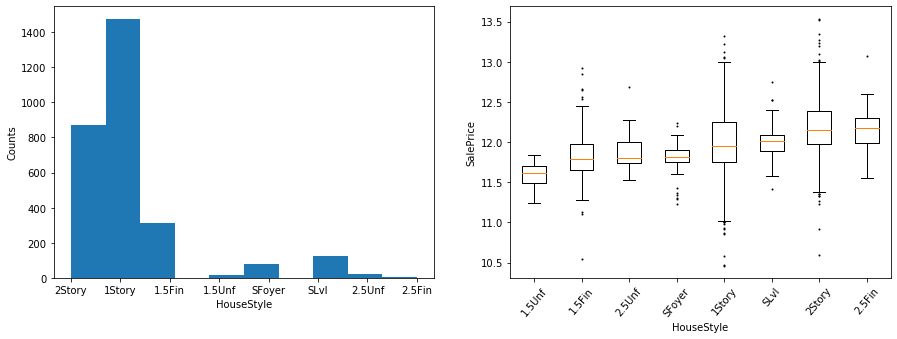

In [55]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

ax = plt.subplot(1,2,1)
plt.hist(X_all['HouseStyle'])
plt.xlabel('HouseStyle')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
data = []
for x in df.index:
        yy = X_all['SalePrice'][X_all['HouseStyle']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, df.index, rotation=50)

plt.xlabel('HouseStyle')
plt.ylabel('SalePrice');

In [56]:
# Divide into low, medium, and high price bins
div = np.array_split(range(len(df.index)), 3)
df['rank'] = [1 for x in df.index[div[0]]] + \
             [2 for x in df.index[div[1]]] + \
             [3 for x in df.index[div[2]]]     
dct = dict(zip(df.index, df['rank']))

X_all['HouseStyle_Price'] = X_all['HouseStyle'].copy().replace(dct).apply(pd.to_numeric)

Correlation with target: 0.3036970426697622
HouseStyle_Price    1.000000
TotalGroundBath     0.527650
2ndFlrSF            0.519556
HalfBath            0.495504
TotalBath           0.433036
Name: HouseStyle_Price, dtype: float64


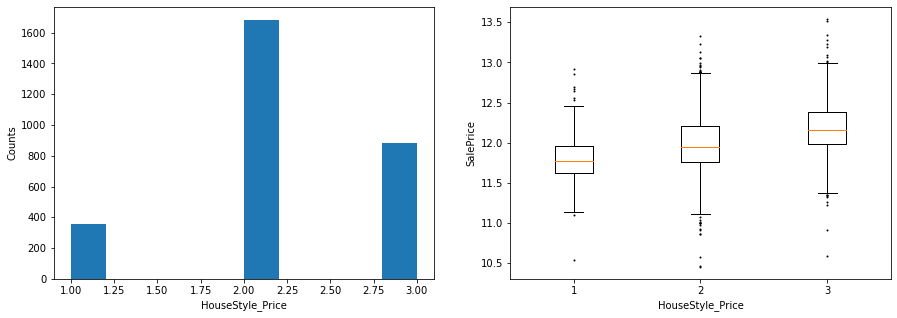

In [57]:
print('Correlation with target:', X_all['HouseStyle_Price'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['HouseStyle_Price']).sort_values(ascending=False)[:5])

# Plotting distribution of new feature

fig = plt.figure(figsize=(15, 5)) # (width,height)

ax = plt.subplot(1,2,1)
plt.hist(X_all['HouseStyle_Price'])
plt.xlabel('HouseStyle_Price')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
data = []
x_vals = [1,2,3]
for x in x_vals:
        yy = X_all['SalePrice'][X_all['HouseStyle_Price']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, x_vals)

plt.xlabel('HouseStyle_Price')
plt.ylabel('SalePrice');


#### Feature binning: GarageType and SalePrice

In [58]:
# Sort GarageType by median SalePrice value:
df = X_all.groupby(['GarageType']).median()[['SalePrice']].sort_values(by='SalePrice')

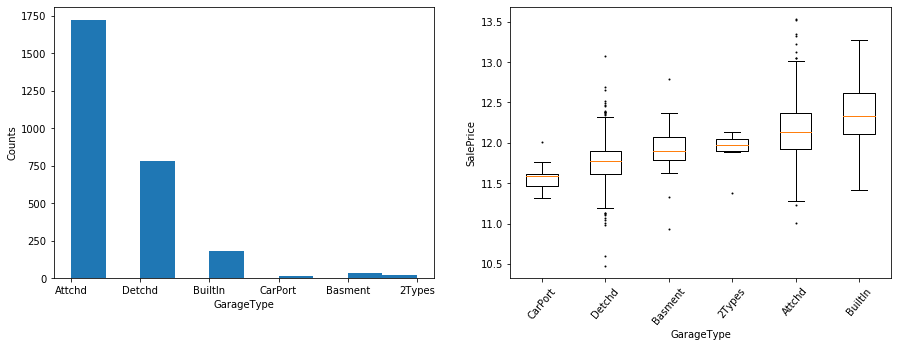

In [59]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

ax = plt.subplot(1,2,1)
plt.hist(X_all['GarageType'].dropna(axis=0))
plt.xlabel('GarageType')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
data = []
for x in df.index:
        yy = X_all['SalePrice'][X_all['GarageType']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, df.index, rotation=50)

plt.xlabel('GarageType')
plt.ylabel('SalePrice');

In [60]:
# Divide into low, medium, and high price bins
div = np.array_split(range(len(df.index)), 3)
df['rank'] = [1 for x in df.index[div[0]]] + \
             [2 for x in df.index[div[1]]] + \
             [3 for x in df.index[div[2]]]
dct = dict(zip(df.index, df['rank']))

X_all['GarageType_Price'] = X_all['GarageType'].copy().replace(dct).apply(pd.to_numeric)

Correlation with target: 0.4989934722177732
GarageType_Price    1.000000
YearBuilt           0.590660
GarageFinish        0.556220
SalePrice           0.498993
SRSSQual            0.461039
Name: GarageType_Price, dtype: float64


/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


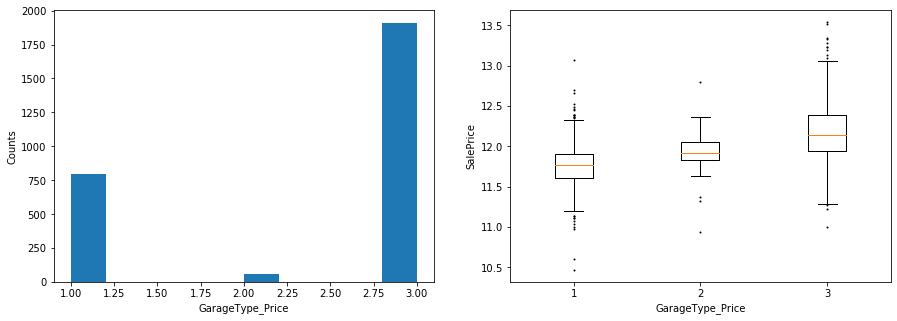

In [61]:
print('Correlation with target:', X_all['GarageType_Price'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['GarageType_Price']).sort_values(ascending=False)[:5])

# Plotting distribution of new feature

fig = plt.figure(figsize=(15, 5)) # (width,height)

ax = plt.subplot(1,2,1)
plt.hist(X_all['GarageType_Price'])
plt.xlabel('GarageType_Price')
plt.ylabel('Counts')

ax = plt.subplot(1,2,2)
data = []
x_vals = [1,2,3]
for x in x_vals:
        yy = X_all['SalePrice'][X_all['GarageType_Price']==x].dropna(axis=0).values
        data.append(yy)
plt.boxplot(data, flierprops=outlier_marker)

locs=ax.get_xticks()
plt.xticks(locs, x_vals)

plt.xlabel('GarageType_Price')
plt.ylabel('SalePrice');


## 4.4 Other new features <a id='section_4.4'></a>

In [62]:
# Remodeled - yes or no
#  idea credit: https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6

remod = []
for ii in range(0,len(X_all)):
    if X_all.iloc[ii]['YearRemodAdd'] > X_all.iloc[ii]['YearBuilt']:
        remod.append(1) # remodel occured
    else:
        remod.append(0) # no remodel

X_all['Remod'] = remod
print('Correlation with target:', X_all['Remod'].corr(X_all['SalePrice']))
print(np.abs(X_all.corr()['Remod']).sort_values(ascending=False)[:4])

Correlation with target: -0.07376108557746104
Remod          1.000000
YearBuilt      0.400690
GarageYrBlt    0.296134
OverallCond    0.268640
Name: Remod, dtype: float64


## 4.5 Polynomial features <a id='section_4.5'></a>
inspired by: https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset

In [63]:
# List of new numerical columns so far...
num_cols_new_temp = list(set(X_all.columns)-set(X.columns)-set(['SalePrice'])
                         -set(X_all.filter(regex='Bin$',axis=1).columns)) # new nominal columns
                         
    
# Calculate correlation between numeric features and target
for col in num_cols_new_temp:
    corr = X_all.loc[:X.shape[0], num_cols+num_cols_new_temp].corrwith(y)
corr_top = list(np.abs(corr).sort_values(ascending=False)[:10].keys())
print('Creating polynomial features for:', corr_top)

# Add polynomial features to training and test data sets
for feature in corr_top:
    X_all[feature+'_2'] = X_all[feature]**2.
    X_all[feature+'_3'] = X_all[feature]**3.
    X_all[feature+'_sqrt'] = X_all[feature]**0.5

Creating polynomial features for: ['SRSSQual', 'TotalHouseArea', 'GrLivArea', 'GarageCars', 'Neighborhood_Price', 'TotalRooms', 'TotalBath', 'GarageArea', 'TotalBsmtSF', 'TotalGroundBath']


## 4.6 Summary of new created features <a id='section_4.6'></a>

In [64]:
# New features list
new_cols0 = list(set(X_all.columns)-set(X.columns)-set(['SalePrice']))
new_cols = new_cols0.copy()

# New nominal features - need to be encoded like nominal data
catnom_cols_new = list(X_all.filter(regex='Bin$',axis=1).columns) 

# New numerical features - need to be imputed like numerical data
num_cols_new = list(set(new_cols0)-set(catnom_cols_new))

In [65]:
# Separate train and test data...
X_new = X_all[:X.shape[0]].drop('SalePrice', axis=1)
X_test_new = X_all[X.shape[0]:].drop('SalePrice', axis=1)
print('Check train and test indicies match originals:', set(X_new.index==X.index), set(X_test_new.index==X_test.index))

Check train and test indicies match originals: {True} {True}


# 5. Data pre-processing <a id='section_5'></a>
Final data preparations before modeling:  
[5.1 Skewed features and log transforms](#section_5.1)  
[5.2 Multicollinearity](#section_5.2)  
[5.3 Removing outliers](#section_5.3)  
[5.4 Python function for convenient pre-processing](#section_5.4)  
[5.5 sklearn Pipeline for pre-processing](#section_5.5)  
[5.6 Final prepping of the data before modeling](#section_5.6)  

In [66]:
# Creating a subset of just numerical + ordinal (training) data for pre-processing analysis
X_pro = X_new[num_cols0+catord_cols0+num_cols_new]

## 5.1 Skewed features and log transforms <a id='section_5.1'></a>
Determine the skew of numeric features and assess if performing a log(1+x) transform is effective at reducing skew.

In [67]:
from scipy.stats import skew
from scipy.stats import skewtest
from scipy.stats import boxcox
from scipy.stats import pearsonr
from scipy.stats import yeojohnson

df = pd.DataFrame(columns=['features', 'skewtest_pval', 'col_skew', 'log1p_skew', 
                           'pdiff(col_skew,log1p_skew)', 'change', 'r2before', 'r2after'])
for i, col in enumerate(num_cols0+num_cols_new+catord_cols):

    transform = 'log_transform' #yj_transform, log_transform
    
    pval = skewtest(X_pro[col])[1]
    col_skew = X_pro[col].skew()
    
    lp_skew = np.log1p(X_pro[col]).skew() # log(1+x) transform
    
    
    pdiff = np.abs(np.abs(col_skew)-np.abs(lp_skew))/np.abs(col_skew) # percent difference
    
    #yj_skew = skew(yeojohnson(X_pro[col])[0]) # yeo-johnson transform
    #pdiff2 =np.abs(np.abs(col_skew)-np.abs(yj_skew))/np.abs(col_skew)
    
    r2before = np.round(X_pro[col].corr(y),decimals=2)
    
    # is a transform of the column effective at reducing skew?
    change=0
    if transform == 'log_transform':
        r2after = np.round(np.log1p(X_pro[col]).corr(y), decimals=2)
        if (pval<0.05) and (pdiff>0.1) and (np.abs(lp_skew)<np.abs(col_skew)) \
            and (np.abs(r2after)>=np.abs(r2before)): # for log(1+x) transform
            change=1
        
    if transform == 'yj_transform':
        r2after = np.round(pearsonr(yeojohnson(X_pro[col][X_pro[col].notnull()])[0], y[X_pro[col].notnull()])[0], decimals=2)
        if (pval<0.05) and (pdiff2>0.1) and (np.abs(yj_skew)<np.abs(col_skew)) and (np.abs(r2after)>=np.abs(r2before)): # yeo-johnson transform
            change=1
               
    df.loc[i]=[col, pval, col_skew, lp_skew, pdiff, change, r2before, r2after]

df = df.sort_values(by='col_skew', ascending=False)

skewed_cols = list(set(df[df['change']==1]['features'])-set(['GarageYrBlt', 'YearBuilt']))
# note: weird things happen to the scale when yj transforming the year columns

df[df['change']==1].head()

,features,skewtest_pval,col_skew,log1p_skew,"pdiff(col_skew,log1p_skew)",change,r2before,r2after
77,TotalBsmtSF_3,0.0,30.247421,-5.152705,0.829648,1,0.20,0.37
33,MiscVal,0.0,24.476794,5.170704,0.788751,1,-0.02,-0.07
42,TotalHouseArea_3,0.0,20.825691,-0.441509,0.978800,1,0.41,0.83
28,LotArea,0.0,12.207688,-0.137404,0.988744,1,0.26,0.40
57,GrLivArea_3,0.0,10.697111,-0.006995,0.999346,1,0.45,0.73


In [68]:
len(skewed_cols)

40

## 5.2 Multicollinearity <a id='section_5.2'></a>
Determine which pairs of features are collinear and only keep the feature of the pair that is most correlated with the target variable.

In [69]:
# Identify features with highest collinearity

corr = X_pro.corr()
df_corr = pd.DataFrame(columns=['feat1','feat2','corr(feat1,feat2)'])
corr_high = corr[(np.abs(corr)<1)&(np.abs(corr)>0.9)]
for col in corr_high.columns: 
    if corr_high[col].count()>0:
        dat = corr_high[col]
        for ii in range(0,len(dat[dat.notnull()].keys())):
            df_corr = df_corr.append({'feat1': col,
                                      'feat2': dat[dat.notnull()].keys()[ii], 
                                      'corr(feat1,feat2)': dat[dat.notnull()].values[ii]}, 
                                      ignore_index=True)
cols_collinear = df_corr['feat1'].unique()
df_corr = df_corr.sort_values(by='corr(feat1,feat2)', ascending=False).drop_duplicates(subset='corr(feat1,feat2)', keep='first')

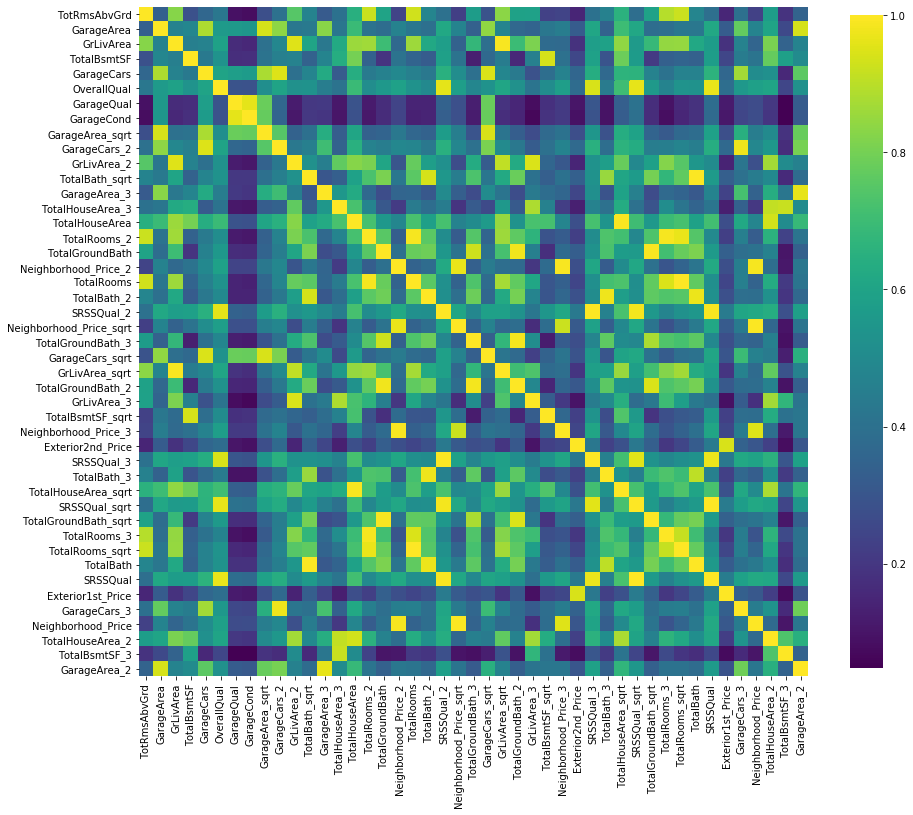

In [70]:
# Plot correlation map of columns with greatest collinearity

corr_map = X_pro[cols_collinear].corr()
fig = plt.figure(figsize=(15, 15)) # (width,height)
sns.heatmap(corr_map, cmap='viridis', square=True, annot=False, annot_kws={'size': 2}, cbar_kws={'shrink': 0.8});

In [71]:
# For correlated pairs of features, keep the feature is more correlated with SalePrice

X_pro = pd.concat([X_pro, y], axis=1)
corr_target = X_pro[list(cols_collinear)+['SalePrice']].corr()['SalePrice']

feat_better = []
feat_worse = []
feat_better_corr = []
feat_worse_corr = []
for ii in range(0,len(df_corr)):
    feat1 = df_corr.iloc[ii]['feat1']
    feat2 = df_corr.iloc[ii]['feat2']
    feat1_corr = corr_target[feat1]
    feat2_corr = corr_target[feat2]
    if np.abs(feat1_corr) > np.abs(feat2_corr):
        feat_better.append(feat1)
        feat_worse.append(feat2)
        feat_better_corr.append(feat1_corr)
        feat_worse_corr.append(feat2_corr)
    else:
        feat_better.append(feat2)
        feat_worse.append(feat1)
        feat_better_corr.append(feat2_corr)
        feat_worse_corr.append(feat1_corr)
df_corr['feat_better'] = feat_better 
df_corr['feat_worse'] = feat_worse
df_corr['corr(feat_better,target)'] = feat_better_corr # correlation of better feature to the target
df_corr['corr(feat_worse,target)'] = feat_worse_corr # correlation of worse feature to the target

In [72]:
df_corr

,feat1,feat2,"corr(feat1,feat2)",feat_better,feat_worse,"corr(feat_better,target)","corr(feat_worse,target)"
95,SRSSQual,SRSSQual_sqrt,0.997536,SRSSQual,SRSSQual_sqrt,0.843403,0.840818
43,TotalRooms,TotalRooms_sqrt,0.996331,TotalRooms_sqrt,TotalRooms,0.670239,0.663901
53,Neighborhood_Price_sqrt,Neighborhood_Price,0.996144,Neighborhood_Price,Neighborhood_Price_sqrt,0.670366,0.664940
70,SRSSQual_3,SRSSQual_2,0.993848,SRSSQual_2,SRSSQual_3,0.838106,0.822784
89,TotalBath,TotalBath_sqrt,0.992583,TotalBath_sqrt,TotalBath,0.663085,0.657798
50,SRSSQual_2,SRSSQual,0.992558,SRSSQual,SRSSQual_2,0.843403,0.838106
6,GrLivArea,GrLivArea_sqrt,0.990938,GrLivArea_sqrt,GrLivArea,0.722694,0.700927
80,TotalGroundBath_sqrt,TotalGroundBath,0.990427,TotalGroundBath_sqrt,TotalGroundBath,0.612966,0.610801
65,Neighborhood_Price_3,Neighborhood_Price_2,0.990358,Neighborhood_Price_2,Neighborhood_Price_3,0.666283,0.648685
28,TotalHouseArea,TotalHouseArea_sqrt,0.989080,TotalHouseArea_sqrt,TotalHouseArea,0.835512,0.812364


In [73]:
# List of columns to remove based on collinearity analysis

cols_remove = list(set(cols_collinear)-set(df_corr['feat_better']))
cols_remove = list(set(cols_collinear)-(set(df_corr['feat_better'])-set(df_corr['feat_worse'])))

In [74]:
cols_remove.sort()
cols_remove

['Exterior2nd_Price',
 'GarageArea_2',
 'GarageArea_3',
 'GarageArea_sqrt',
 'GarageCars_2',
 'GarageCars_3',
 'GarageCars_sqrt',
 'GarageCond',
 'GrLivArea',
 'GrLivArea_2',
 'GrLivArea_3',
 'Neighborhood_Price_2',
 'Neighborhood_Price_3',
 'Neighborhood_Price_sqrt',
 'OverallQual',
 'SRSSQual_2',
 'SRSSQual_3',
 'SRSSQual_sqrt',
 'TotRmsAbvGrd',
 'TotalBath',
 'TotalBath_2',
 'TotalBath_3',
 'TotalBsmtSF_3',
 'TotalBsmtSF_sqrt',
 'TotalGroundBath',
 'TotalGroundBath_2',
 'TotalGroundBath_3',
 'TotalHouseArea',
 'TotalHouseArea_2',
 'TotalHouseArea_3',
 'TotalRooms',
 'TotalRooms_2',
 'TotalRooms_3']

## 5.3 Removing outliers <a id='section_5.3'></a>

Outliers are identified here using Cook's Distance on continuous numeric features that are highly correlated with the target.

In [75]:
# Select continuous numeric columns    
col_float = []
for col in X_pro.columns:
    if len(X_pro[col].unique())>20:
        col_float.append(col)

# Remove polynomial columns from this analysis... they're not necessary here
col_float = list(set(col_float)-set(X_all.filter(regex='2$',axis=1).columns)
                 -set(X_all.filter(regex='3$',axis=1).columns)-set(X_all.filter(regex='sqrt$',axis=1).columns))

# Calculate correlation between features and target
corr = X_pro[col_float].corrwith(y)
print(corr.sort_values(ascending=False)[:15])

col_float_sorted = list(np.abs(corr).sort_values(ascending=False).keys())
col_float_sorted.remove('SalePrice')
corr_top = col_float_sorted[:12]

print(len(corr_top))
print()
print(col_float_sorted)

SalePrice             1.000000
SRSSQual              0.843403
TotalHouseArea        0.812364
GrLivArea             0.700927
GarageArea            0.650888
TotalBsmtSF           0.612134
1stFlrSF              0.596981
YearBuilt             0.586570
GarageYrBlt           0.568696
YearRemodAdd          0.565608
MasVnrArea            0.426776
TotalDeckPorchArea    0.398387
BsmtFinSF1            0.372023
LotFrontage           0.355879
WoodDeckSF            0.334135
dtype: float64
12

['SRSSQual', 'TotalHouseArea', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'YearBuilt', 'GarageYrBlt', 'YearRemodAdd', 'MasVnrArea', 'TotalDeckPorchArea', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'LotArea', 'BsmtUnfSF', 'EnclosedPorch', 'ScreenPorch', 'LowQualFinSF', 'MiscVal']


In [76]:
from sklearn.impute import SimpleImputer

# Use the features with the highest correlation to calculate Cook's Distance
X_cookd = X_pro.copy()[corr_top]

# Need to impute missing data for this analysis
X_cookd = pd.DataFrame(SimpleImputer(strategy='median').fit_transform(X_cookd), index=X.index)
X_cookd.columns = corr_top

# Don't worry about outliers on low saleprice end... very few data points
X_cookd = X_cookd.iloc[np.where(y>11.5)[0]]

/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/opt/local/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/yellowbrick/regressor/influence.py:183: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significan

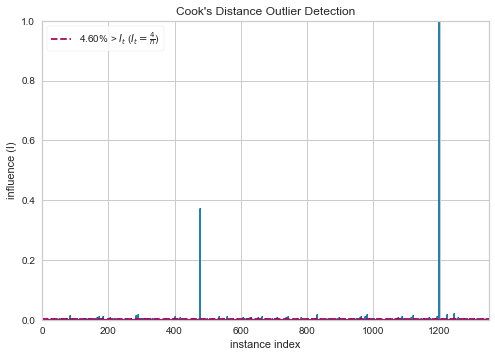

In [77]:
from yellowbrick.regressor import CooksDistance

# Instantiate and fit the visualizer
visualizer = CooksDistance()
visualizer.fit(X_cookd, y[X_cookd.index])
plt.ylim(0,1)
visualizer.show();

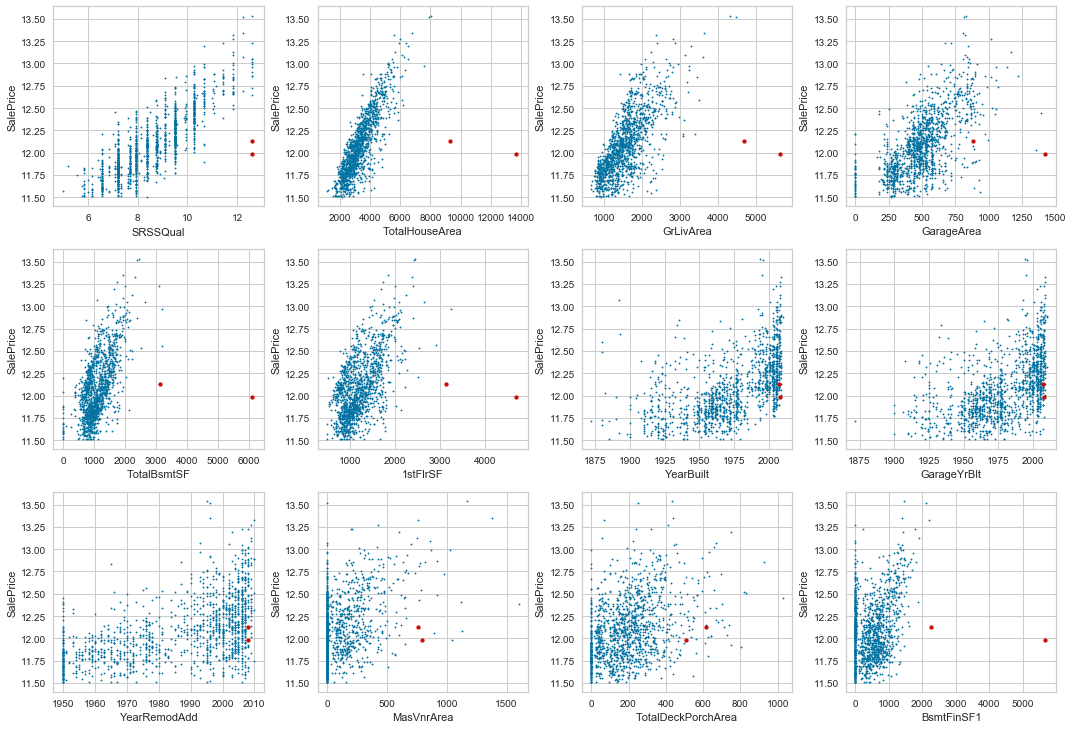

In [78]:
# Visually inspect the identified outliers

cookd = visualizer.distance_.values
index_outliers = np.where(cookd>0.3)[0]
index_outliers_labels = X_cookd.index[index_outliers]
X_outliers = X_cookd.loc[index_outliers_labels]
y_outliers = y[X_cookd.index].loc[index_outliers_labels]

fig = plt.figure(figsize=(15, 20)) # (width,height)
for index, col in enumerate(X_outliers.columns):
    ax = fig.add_subplot(6, 4, index+1)
    plt.scatter(X_cookd[col], y[X_cookd.index], c='b', s=2) # normal = blue
    plt.scatter(X_outliers[col], y_outliers, c='r', s=15) # outlier = red
    plt.xlabel(col)
    plt.ylabel('SalePrice')
plt.tight_layout()

In [79]:
# Final selected outliers

X_outliers = pd.concat([X_outliers, y], axis=1).loc[index_outliers_labels]
X_outliers

,SRSSQual,TotalHouseArea,GrLivArea,GarageArea,TotalBsmtSF,1stFlrSF,YearBuilt,GarageYrBlt,YearRemodAdd,MasVnrArea,TotalDeckPorchArea,BsmtFinSF1,SalePrice
Id,,,,,,,,,,,,,
524,12.60952,9312.0,4676.0,884.0,3138.0,3138.0,2007.0,2007.0,2008.0,762.0,614.0,2260.0,12.126764
1299,12.60952,13676.0,5642.0,1418.0,6110.0,4692.0,2008.0,2008.0,2008.0,796.0,506.0,5644.0,11.982935


## 5.4 python function for convenient pre-processing <a id='section_5.4'></a>
I end up using an sklearn pipeline to incorporate preprocessing in my final results, but this function is useful to have.

In [80]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.impute import SimpleImputer

def preprocess(X, y=None, num_cols=None, catord_cols=None, catnom_cols=None, skewed_cols = None, append_target=0):
    
    frames = []
    
    '''
    numeric features
    '''
    if num_cols != None:
        
        # impute missing with median
        imputer = SimpleImputer(strategy='median').fit(X[num_cols])
        X_imputed = pd.DataFrame(imputer.transform(X[num_cols]), index=X.index)
        X_imputed.columns = num_cols
        
        # apply scaler
        X_scaled = pd.DataFrame(RobustScaler().fit_transform(X_imputed), index=X.index)
        X_scaled.columns = num_cols
        
        frames.append(X_scaled.apply(pd.to_numeric))
    
    '''
    ordinal features
    '''
    if catord_cols != None:
        
        # apply label encoding
        enc = CustomOrdinalEncoder().fit(X[catord_cols])
        X_encoded = enc.transform(X[catord_cols])
        
        # impute missing with most frequent
        imputer = SimpleImputer(strategy='most_frequent').fit(X_encoded[catord_cols])
        X_imputed = pd.DataFrame(imputer.transform(X_encoded[catord_cols]), index=X.index)
        X_imputed.columns = catord_cols
        
        # apply scaler
        X_scaled = pd.DataFrame(RobustScaler().fit_transform(X_imputed), index=X.index)
        X_scaled.columns = catord_cols
        
        frames.append(X_scaled.apply(pd.to_numeric))
    
    '''
    nominal features
    '''
    if catnom_cols != None:
        
        # apply one-hot encoding
        X[catnom_cols] = X[catnom_cols].fillna(value='None')
        X_encoded_catnom = pd.get_dummies(X[catnom_cols])
        
        frames.append(X_encoded_catnom)

    '''
    target variable
    '''
    if append_target == 1:
        frames.append(y)
        
    return pd.concat(frames, axis=1) #axis=1 is very important!

## 5.5 sklearn Pipeline for pre-processing <a id='section_5.5'></a>

This pipeline setup will take care of imputation, scaling, and encoding of features within the cross-validation of a model.

In [81]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', RobustScaler())
])  


# Preprocessing for categorical-ordinal data
ordinal_transformer = Pipeline(steps=[
    ('encoder', CustomOrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', RobustScaler())
])  


# Preproessing for categorical-nominal dta
nominal_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='None')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])  


# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols),
        ('catord', ordinal_transformer, catord_cols),
        ('catnom', nominal_transformer, catnom_cols)
    ])

## 5.6 Final prepping of the data before modeling <a id='section_5.6'></a>
Removing outliers, dropping collinear columns, and performing log(1+x) transforms on skewed columns

In [82]:
# Removing outliers
X_clean_full = X_new.drop(index_outliers_labels, axis=0)
y_clean = y.drop(index_outliers_labels, axis=0)
X_test_clean_full = X_test_new.copy()

# Revising list of features to take into account the addition of new features
num_cols_final_full = list(set(list(num_cols0)+list(num_cols_new)))
catord_cols_final_full = list(set(list(catord_cols0)))
catnom_cols_final_full = list(set(list(catnom_cols0)+list(catnom_cols_new)))

# Transforming skewed columns 
for col in skewed_cols:
    X_clean_full[col] = np.log1p(X_clean_full[col]) 
    X_test_clean_full[col] = np.log1p(X_test_clean_full[col]) 
    
# Dropping collinear features
X_clean = X_clean_full.drop(cols_remove, axis=1) #cols_remove from multicollinearity analysis
X_test_clean = X_test_clean_full.drop(cols_remove, axis=1) #cols_remove from multicollinearity analysis

num_cols_final = list(set(num_cols_final_full)-set(cols_remove))
catord_cols_final = list(set(catord_cols_final_full)-set(cols_remove))
catnom_cols_final = list(set(catnom_cols_final_full)-set(cols_remove))

In [83]:
# For convenience, processing via python function...
X_pro_full = preprocess(X_clean_full, y_clean, 
                       num_cols = num_cols_final,
                       catord_cols = catord_cols_final,
                       catnom_cols = catnom_cols_final,
                       append_target=0)

X_pro = preprocess(X_clean, y_clean, 
                   num_cols = num_cols_final,
                   catord_cols = catord_cols_final,
                   catnom_cols = catnom_cols_final,
                   append_target=0)

# 6. Lasso modeling <a id='section_6'></a>

[6.1 Lasso: Tuning hyperparameters](#section_6.1)  
[6.2 Lasso: Model fitting and CV scores](#section_6.2)    
[6.3 Lasso: Evaluating model fit](#section_6.3)  
[6.4 Lasso: Feature importances ](#section_6.4)    
[6.5 Lasso: Making predictions](#section_6.5)   

## 6.1 Lasso: Tuning hyperparameters <a id='section_6.1'></a>

In [84]:
# Note: LassoCV is much faster than GridSearchCV
from sklearn.linear_model import LassoCV

clf = LassoCV(alphas=np.geomspace(0.0001, 1, 100),
              max_iter=10000,
              cv=5,).fit(X_pro,y_clean)

best_alpha_lasso = clf.alpha_
print('Lasso model: best alpha =', best_alpha_lasso)

Lasso model: best alpha = 0.00048626015800653534


## 6.2 Lasso: Model fitting and CV scores <a id='section_6.2'></a>

In [85]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score

# Define model
model = Lasso(alpha=best_alpha_lasso, max_iter=100000)

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_final),
        ('catord', ordinal_transformer, catord_cols_final),
        ('catnom', nominal_transformer, catnom_cols_final)
    ])

# Pipeline for preprocessing and modeling
lasso_clf = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', model)
                           ])

# Apply preprocessing and train model 
lasso_clf.fit(X_clean, y_clean)

# Cross validation scores for model
scores = cross_val_score(lasso_clf, 
                         X_clean, y_clean, 
                         scoring='neg_root_mean_squared_error', 
                         cv=5) 

print("Lasso Cross-validation scores: {}".format(scores))
print()
print("Lasso Mean CV score: {}".format(-np.mean(scores)))

Lasso Cross-validation scores: [-0.10432773 -0.10883208 -0.11561737 -0.10044797 -0.11116569]

Lasso Mean CV score: 0.10807816749025694


## 6.3 Lasso: Evaluating model fit <a id='section_6.3'></a>
Useful reference: http://docs.statwing.com/interpreting-residual-plots-to-improve-your-regression

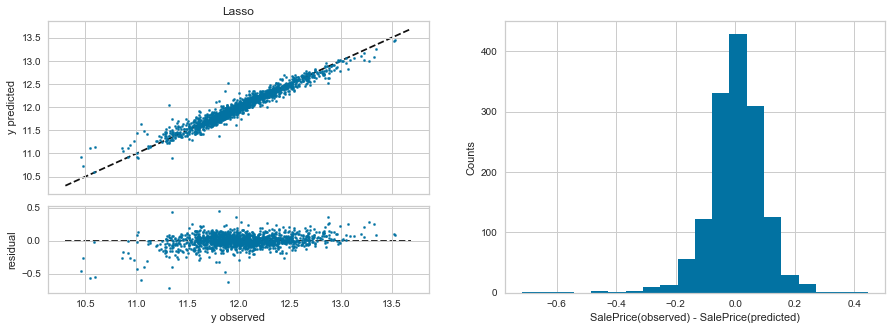

In [86]:
from matplotlib import gridspec

fig = plt.figure(figsize=(15, 5)) # (width,height)
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1]) 

y_predicted_lasso = lasso_clf.predict(X_clean)
residuals_lasso = y_clean-y_predicted_lasso
residuals_lasso_dollars = np.expm1(y_clean)-np.expm1(y_predicted_lasso)

# y_predicted vs y_observed
ax0 = plt.subplot(gs[0,0])
ax0.scatter(y_clean, y_predicted_lasso, s=5)

x_plt = np.linspace(plt.xlim()[0], plt.xlim()[1], 5)
plt.plot(x_plt, x_plt, '--', c='k', zorder=-1)

ax0.set_title('Lasso')
ax0.set_ylabel('y predicted')
plt.setp(ax0.get_xticklabels(), visible=False)

# residual vs y_observed
ax1 = plt.subplot(gs[1,0])
ax1.scatter(y_clean, residuals_lasso, s=5)

xplt = np.linspace(plt.xlim()[0], plt.xlim()[1], 5)
plt.plot(x_plt, np.zeros(len(x_plt)), '--', c='k', zorder=-1)

ax1.set_xlabel('y observed')
ax1.set_ylabel('residual')

plt.subplots_adjust(hspace=0.1)


# Histogram of residuals
ax2 = plt.subplot(1,2,2)
plt.hist(residuals_lasso, 20)
plt.xlabel('SalePrice(observed) - SalePrice(predicted)')
plt.ylabel('Counts');

In [87]:
print(residuals_lasso.describe())
print()
print('Lasso residuals skew:', np.round(residuals_lasso.skew(),1))
print('Lasso residuals kurtosis:', np.round(residuals_lasso.kurtosis(),1))

count    1.458000e+03
mean    -4.239864e-16
std      9.825255e-02
min     -7.175598e-01
25%     -4.686584e-02
50%      1.168588e-03
75%      5.293323e-02
max      4.451065e-01
Name: SalePrice, dtype: float64

Lasso residuals skew: -1.1
Lasso residuals kurtosis: 7.0


The residuals for the Lasso model are generally small. The distribution of residuals is centered at ~0, with a slight negative skew of -1.1.

There are no obvious patterns in the plot of residuals vs. observed sale price, indicating the Lasso model is a good fit. However, this model has a tendency to overpredict sale price in the lowest price regime, and underpredict sale price in the highest price regime.

## 6.4 Lasso: Feature importances <a id='section_6.4'></a>

In [88]:
# Feature names from the preprocessor pipeline
clf_num = lasso_clf.named_steps['preprocessor'].transformers_[0][2] # numerical
clf_catord = lasso_clf.named_steps['preprocessor'].transformers_[1][2] # categorical
clf_catnom = lasso_clf.named_steps['preprocessor'].transformers_[2][1]['onehot'].get_feature_names(catnom_cols_final) #nominal

# Creating a dataframe of features sorted by importance
lasso_coef = pd.concat([pd.Series(list(clf_num)+list(clf_catord)+list(clf_catnom), name='features'), 
                        pd.Series(lasso_clf.named_steps['model'].coef_, name='coef')], axis=1).sort_values(by='coef')

print('Features selected by Lasso:', len(np.where(lasso_coef['coef']!=0)[0]), '/', len(lasso_coef))
print('Fraction of features selected by Lasso:', np.round(len(np.where(lasso_coef['coef']!=0)[0])/len(lasso_coef), 2))

Features selected by Lasso: 103 / 280
Fraction of features selected by Lasso: 0.37


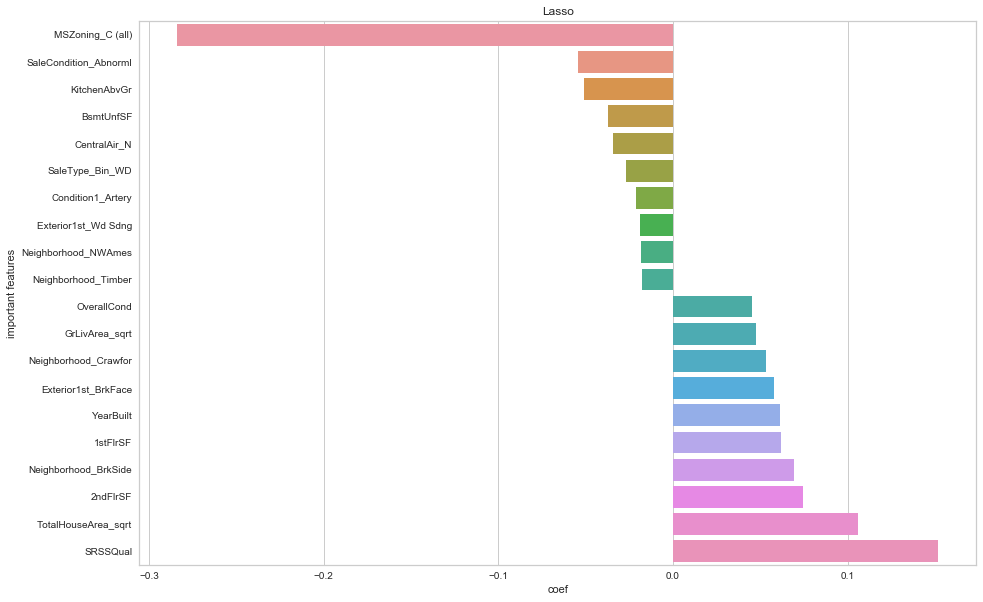

In [89]:
# Plotting lasso feature importances 

#lasso_coef['abs(coef)'] = np.abs(lasso_coef['coef'])
#lasso_coef = lasso_coef.sort_values(by='abs(coef)', ascending=False)

coef_plt = pd.concat([lasso_coef[:10], lasso_coef[-10:]],axis=0)


fig = plt.figure(figsize=(15, 10)) # (width,height)

ax = plt.subplot(1,1,1)

sns.set_color_codes("pastel")
sns.barplot(x="coef", y="features", data=coef_plt)
ax.set(ylabel='important features')
ax.set_title('Lasso');


Surprisingly, the most important feature for the Lasso model is MSZoning_C(all) - being assigned to a commercial zone has a strong negative effect on the predicted sale price. Other negative effects that act to reduce sale price include no central air (CentralAir_N), an unfinished basement (BsmtUnfSF), and proximity to a busy street (Condition1_Artery). Abnormal sales (SaleCondition_Abnorml) were also associated with lower housing sale prices.

Area related features (TotalHouseArea, 2ndFlrSF, 1stFlrSF, GrLivArea) have a strong positive effect on sale price, which makes sense - larger houses typically sell for more. Other positive features include the overall quality of the house (SRSSQual) and newer houses (YearBuilt).

The neighborhood a house is located in also has a substantial effect on the sale price of the house as evidenced by a few specific neighborhoods having a large coefficient, either positive or negative.

## 6.5 Lasso: Making predictions <a id='section_6.5'></a>

In [90]:
# Saving the Lasso predictions for the test data
y_test_lasso = np.expm1(lasso_clf.predict(X_test_clean))
output = pd.DataFrame({'Id': X_test.index, 
                       'SalePrice': y_test_lasso})
output.to_csv('./output/submission_lasso.csv', index=False)

# 7. Ridge modeling <a id='section_7'></a>
 
[7.1 Ridge: tuning hyperparameters](#section_7.1)  
[7.2 Ridge: Model fitting and CV scores](#section_7.2)    
[7.3 Ridge: Evaluating model fit](#section_7.3)  
[7.4 Ridge: Feature importances ](#section_7.4)    
[7.5 Ridge: Making predictions](#section_7.5)   

## 7.1 Ridge: tuning hyperparameters <a id='section_7.1'></a>

In [91]:
# Note: RidgeCV is much faster than GridSearchCV
from sklearn.linear_model import RidgeCV

clf = RidgeCV(alphas=np.geomspace(1, 50, 100)).fit(X_pro,y_clean)

best_alpha_ridge = clf.alpha_
print('Ridge model: best alpha =', best_alpha_ridge)

Ridge model: best alpha = 11.587811365954495


## 7.2 Ridge: Model fitting and CV scores <a id='section_7.2'></a>

In [92]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

# Define model
model = Ridge(alpha=best_alpha_ridge, max_iter=100000)

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_final),
        ('catord', ordinal_transformer, catord_cols_final),
        ('catnom', nominal_transformer, catnom_cols_final)
    ])

# Pipeline for preprocessing and modeling
ridge_clf = Pipeline(steps=[('preprocessor', preprocessor),
                            ('model', model)
                           ])

# Apply preprocessing and train model 
ridge_clf.fit(X_clean, y_clean)

# Cross validation scores for model
scores = cross_val_score(ridge_clf, 
                         X_clean, y_clean, 
                         scoring='neg_root_mean_squared_error', 
                         cv=5) 

print("Ridge Cross-validation scores: {}".format(scores))
print()
print("Ridge Mean CV score: {}".format(-np.mean(scores)))

Ridge Cross-validation scores: [-0.10725027 -0.11389785 -0.11742742 -0.10329174 -0.11453159]

Ridge Mean CV score: 0.11127977455585095


## 7.3 Ridge: Evaluating model fit <a id='section_7.3'></a>

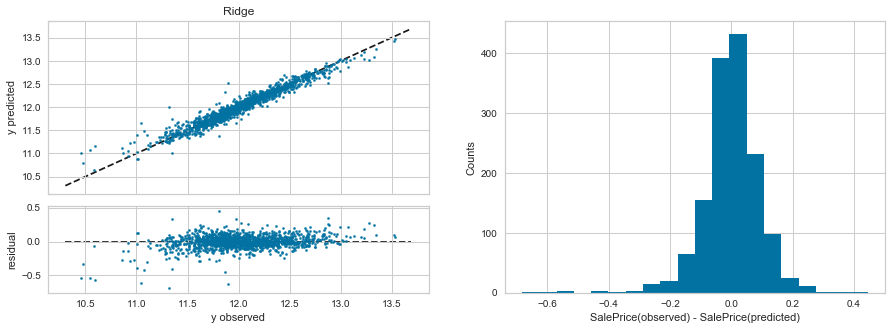

In [93]:
from matplotlib import gridspec

fig = plt.figure(figsize=(15, 5)) # (width,height)
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1]) 

y_predicted_ridge = ridge_clf.predict(X_clean)
residuals_ridge = y_clean-y_predicted_ridge
residuals_ridge_dollars = np.expm1(y_clean)-np.expm1(y_predicted_ridge)

# y_predicted vs y_observed
ax0 = plt.subplot(gs[0,0])
ax0.scatter(y_clean, y_predicted_ridge, s=5)

x_plt = np.linspace(plt.xlim()[0], plt.xlim()[1], 5)
plt.plot(x_plt, x_plt, '--', c='k', zorder=-1)

ax0.set_title('Ridge')
ax0.set_ylabel('y predicted')
plt.setp(ax0.get_xticklabels(), visible=False)

# residual vs y_observed
ax1 = plt.subplot(gs[1,0])
ax1.scatter(y_clean, residuals_ridge, s=5)

xplt = np.linspace(plt.xlim()[0], plt.xlim()[1], 5)
plt.plot(x_plt, np.zeros(len(x_plt)), '--', c='k', zorder=-1)

ax1.set_xlabel('y observed')
ax1.set_ylabel('residual')

plt.subplots_adjust(hspace=0.1)


# Histogram of residuals
ax2 = plt.subplot(1,2,2)
plt.hist(residuals_ridge, 20)
plt.xlabel('SalePrice(observed) - SalePrice(predicted)')
plt.ylabel('Counts');

In [94]:
print(residuals_ridge.describe())
print()
print('Ridge residuals skew:', np.round(residuals_ridge.skew(),1))
print('Ridge residuals kurtosis:', np.round(residuals_ridge.kurtosis(),1))

count    1.458000e+03
mean    -1.480297e-15
std      9.570804e-02
min     -6.827905e-01
25%     -4.520547e-02
50%      2.012978e-03
75%      5.110763e-02
max      4.452144e-01
Name: SalePrice, dtype: float64

Ridge residuals skew: -1.1
Ridge residuals kurtosis: 7.3


## 7.4 Ridge: Feature importances <a id='section_7.4'></a>

In [95]:
# Feature names from the preprocessor pipeline
clf_num = ridge_clf.named_steps['preprocessor'].transformers_[0][2] # numerical
clf_catord = ridge_clf.named_steps['preprocessor'].transformers_[1][2] # categorical
clf_catnom = ridge_clf.named_steps['preprocessor'].transformers_[2][1]['onehot'].get_feature_names(catnom_cols_final) #nominal

# Creating a dataframe of features sorted by importance
ridge_coef = pd.concat([pd.Series(list(clf_num)+list(clf_catord)+list(clf_catnom), name='features'), 
                        pd.Series(ridge_clf.named_steps['model'].coef_, name='coef')], axis=1).sort_values(by='coef')

print('Features selected by Ridge:', len(np.where(ridge_coef['coef']!=0)[0]), '/', len(ridge_coef))
print('Fraction of features selected by Ridge:', np.round(len(np.where(ridge_coef['coef']!=0)[0])/len(ridge_coef), 2))

Features selected by Ridge: 278 / 280
Fraction of features selected by Ridge: 0.99


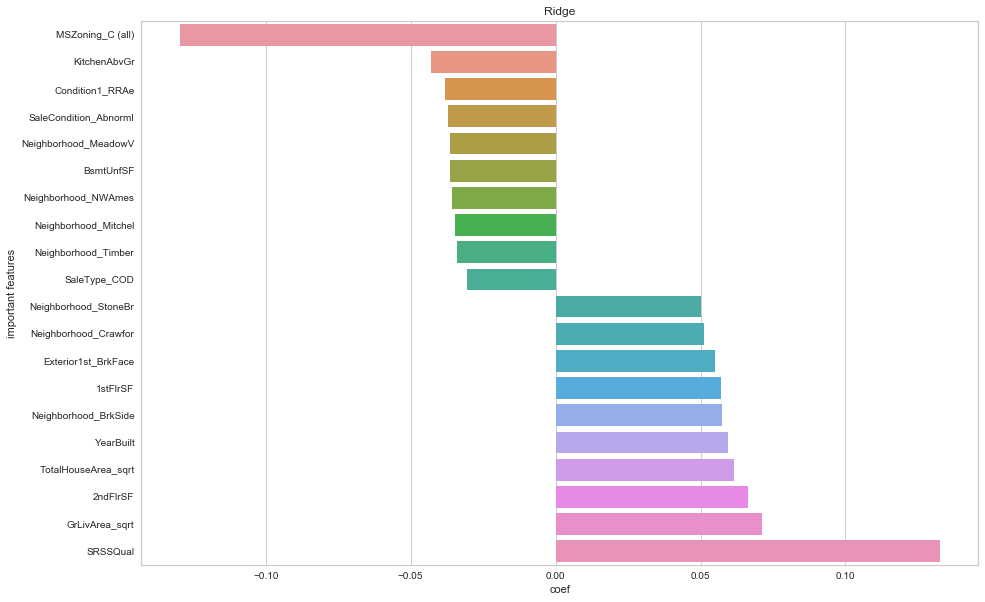

In [96]:
# Plotting ridge feature importances 

coef_plt = pd.concat([ridge_coef[:10], ridge_coef[-10:]],axis=0)


fig = plt.figure(figsize=(15, 10)) # (width,height)

ax = plt.subplot(1,1,1)

sns.set_color_codes("pastel")
sns.barplot(x="coef", y="features", data=coef_plt)
ax.set(ylabel='important features')
ax.set_title('Ridge');


Similar, but different feature importances as compared to Lasso.

## 7.5 Ridge: Making predictions <a id='section_7.5'></a>

In [97]:
# Saving the Ridge predictions for the test data
y_test_ridge = np.expm1(ridge_clf.predict(X_test_clean))
output = pd.DataFrame({'Id': X_test.index, 
                       'SalePrice': y_test_ridge})
output.to_csv('./output/submission_ridge.csv', index=False)

# 8. XGBoost modeling <a id='section_8'></a>
 
[8.1 XGBoost: Establishing a baseline](#section_8.1)  
[8.2 XGBoost: Model fitting](#section_8.2)  
[8.3 XGBoost: Evaluating model fit](#section_8.3)  
[8.4 XGBoost: Feature importances](#section_8.4)    
[8.5 XGBoost: Making predictions](#section_8.5)  

## 8.1 XGBoost: Establishing a baseline <a id='section_8.1'></a>
XGBoost has a lot of hyperparameters, and the data set has a lot of features. I'll establish what a baseline fit looks like before making adjustments.

In [98]:
from xgboost import XGBRegressor

model = XGBRegressor(objective='reg:squarederror', random_state=0)

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_final),
        ('catord', ordinal_transformer, catord_cols_final),
        ('catnom', nominal_transformer, catnom_cols_final)
    ])

# Pipeline for preprocessing and modeling
xgb_clf = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])

# Apply preprocessing and train model 
xgb_clf.fit(X_clean, y_clean)

# Cross validation scores for model
scores = cross_val_score(xgb_clf, 
                         X_clean, y_clean, 
                         scoring='neg_root_mean_squared_error', 
                         cv=5) 

print("Baseline XGBoost Mean CV score: {}".format(-np.mean(scores)))

/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated a

Baseline XGBoost Mean CV score: 0.1177337153582005


In [99]:
# Feature names from the preprocessor 
clf_num = xgb_clf.named_steps['preprocessor'].transformers_[0][2] # numerical
clf_catord = xgb_clf.named_steps['preprocessor'].transformers_[1][2] # categorical
clf_catnom = xgb_clf.named_steps['preprocessor'].transformers_[2][1]['onehot'].get_feature_names(catnom_cols_final) #nominal

# Creating dataframe of features sorted by importance
xgb_fi = pd.concat([pd.Series(list(clf_num)+list(clf_catord)+list(clf_catnom), name='feature'), 
                    pd.Series(xgb_clf.named_steps['model'].feature_importances_, name='importance')], 
                    axis=1).sort_values(by='importance', ascending=False)

print('Baseline: Features selected by XGBoost:', len(np.where(xgb_fi['importance']!=0)[0]), '/', len(xgb_fi))
print('Baseline: Fraction of features selected by XGBoost:', np.round(len(np.where(xgb_fi['importance']!=0)[0])/len(xgb_fi),2))
print('Baseline: Minimum feature importance:',min(xgb_fi['importance'][xgb_fi['importance']!=0]))

Baseline: Features selected by XGBoost: 84 / 280
Baseline: Fraction of features selected by XGBoost: 0.3
Baseline: Minimum feature importance: 0.000315230485284701


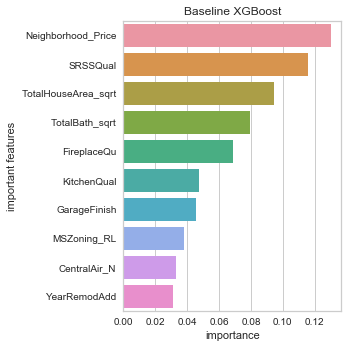

In [100]:
# Plotting xgb feature importances 

fig = plt.figure(figsize=(5, 5)) # (width,height)

ax = plt.subplot(1,1,1)
xgb_fi_plt = xgb_fi[:10]

sns.set_color_codes("pastel")
sns.barplot(x="importance", y="feature", data=xgb_fi_plt)
ax.set(ylabel='important features')
ax.set_title('Baseline XGBoost');

plt.tight_layout()

The baseline XGBoost fit reduces the number of features from 280 to 84. This reduced number of features seems more reasonable, so going forwards with this model I'll only select those features that had non-zero importance in the baseline fit. This should put a limit to the number of features used by XGBoost during hyperparameter tuning and hopefully reduce overfitting.

Note: Initially I did try to tune the hyperparameters using all of the features and inevitably what would be returned is a more complex model with non-zero importances for nearly all features and high n_estimators for the model. The CV scores improve by reducing the number of features so it is a good thing to do.

## 8.2 XGBoost: Model fitting <a id='section_8.2'></a>

Useful references for tuning XGBoost:  
https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/  
http://danielhnyk.cz/how-to-use-xgboost-in-python/

In [101]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel

model = XGBRegressor(objective='reg:squarederror', random_state=0)

# Hyperparameters of XGBoost to optimize
param_grid = {
    'model__learning_rate':  np.linspace(0.05, 0.11, 4),  #initial: np.linspace(0.05, 0.2, 6)
    'model__n_estimators': [150, 200, 250, 300], #[150, 200, 250, 300, 350, 400]
    'model__max_depth': [int(x) for x in np.linspace(3,15,7)], 
    'model__min_child_weight': np.linspace(1,10,4),
    'model__colsample_bytree': [0.6, 0.8, 1], 
    'model__subsample': [0.6, 0.8, 1]
}

# Preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_cols_final),
        ('catord', ordinal_transformer, catord_cols_final),
        ('catnom', nominal_transformer, catnom_cols_final)
    ])


# Pipeline for preprocessing and modeling
clf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('feature_selection', SelectFromModel(model, threshold=10**-5.)),
                               ('model', model)
                              ])

# Tune hyperparameters of model through randomized search
xgb_clf = RandomizedSearchCV(estimator=clf_pipeline,
                             param_distributions=param_grid,
                             n_iter=60,
                             cv=5,
                             scoring='neg_root_mean_squared_error',
                             verbose=2,
                             n_jobs=-1,
                             random_state=0)

# Optimize model parameters, apply preprocessing, and train model                          
xgb_clf.fit(X_clean, y_clean)

# print out results
print(xgb_clf.best_params_)
print()
ind = np.where(xgb_clf.cv_results_['mean_test_score']==max(xgb_clf.cv_results_['mean_test_score']))[0][0]
print('Random search: XGBoost Mean CV score:', -xgb_clf.cv_results_['mean_test_score'][ind])
print()
print(xgb_clf.best_estimator_[2]) #use [1] for no selection, [2] if selection
print()

Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  9.0min finished
/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/Users/alishakundert/Library/Python/3.7/lib/python/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


{'model__subsample': 0.8, 'model__n_estimators': 200, 'model__min_child_weight': 7.0, 'model__max_depth': 5, 'model__learning_rate': 0.05, 'model__colsample_bytree': 0.8}

Random search: XGBoost Mean CV score: 0.11268758233636941

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0,
             importance_type='gain', learning_rate=0.05, max_delta_step=0,
             max_depth=5, min_child_weight=7.0, missing=None, n_estimators=200,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=0.8, verbosity=1)



## 8.3 XGBoost: Evaluating model fit <a id='section_8.3'></a>

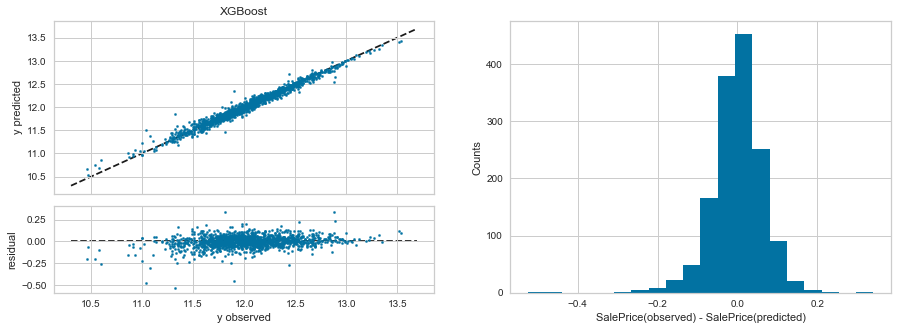

In [102]:
from matplotlib import gridspec

fig = plt.figure(figsize=(15, 5)) # (width,height)
gs = gridspec.GridSpec(2, 2, height_ratios=[2, 1]) 

y_predicted_xgb = xgb_clf.predict(X_clean)
residuals_xgb = y_clean-y_predicted_xgb
residuals_xgb_dollars = np.expm1(y_clean)-np.expm1(y_predicted_xgb)

# y_predicted vs y_observed
ax0 = plt.subplot(gs[0,0])
ax0.scatter(y_clean, y_predicted_xgb, s=5)

x_plt = np.linspace(plt.xlim()[0], plt.xlim()[1], 5)
plt.plot(x_plt, x_plt, '--', c='k', zorder=-1)

ax0.set_title('XGBoost')
ax0.set_ylabel('y predicted')
plt.setp(ax0.get_xticklabels(), visible=False)

# residual vs y_observed
ax1 = plt.subplot(gs[1,0])
ax1.scatter(y_clean, residuals_xgb, s=5)

xplt = np.linspace(plt.xlim()[0], plt.xlim()[1], 5)
plt.plot(x_plt, np.zeros(len(x_plt)), '--', c='k', zorder=-1)

ax1.set_xlabel('y observed')
ax1.set_ylabel('residual')

plt.subplots_adjust(hspace=0.1)


# Histogram of residuals
ax2 = plt.subplot(1,2,2)
plt.hist(residuals_xgb, 20)
plt.xlabel('SalePrice(observed) - SalePrice(predicted)')
plt.ylabel('Counts');

In [103]:
print(residuals_xgb.describe())
print()
print('XGBoost residuals skew:', np.round(residuals_xgb.skew(),1))
print('XGBoost residuals kurtosis:', np.round(residuals_xgb.kurtosis(),1))

count    1458.000000
mean        0.000288
std         0.066361
min        -0.525905
25%        -0.033551
50%         0.001722
75%         0.037818
max         0.340540
Name: SalePrice, dtype: float64

XGBoost residuals skew: -0.9
XGBoost residuals kurtosis: 7.3


The residuals for the XGBoost model are somewhat smaller than those from Lasso; the standard deviation of the residuals for XGBoost is ~0.7 times the standard deviation for the residuals from Lasso. XGBoost additionally has better predictive abilities (i.e. smaller residuals) in the lowest and highest sale price regimes as compared to Lasso.

## 8.4 XGBoost: Feature importances <a id='section_8.4'></a>

In [104]:
# RandomizedSearchCV feature importances

# Feature names from the preprocessor 
clf_num = xgb_clf.best_estimator_['preprocessor'].transformers_[0][2] # numerical
clf_catord = xgb_clf.best_estimator_['preprocessor'].transformers_[1][2] # categorical
clf_catnom = xgb_clf.best_estimator_['preprocessor'].transformers_[2][1]['onehot'].get_feature_names(catnom_cols_final)

# Features selected by SelectFromModel
clf_features = list(clf_num)+list(clf_catord)+list(clf_catnom)
ind_selected = xgb_clf.best_estimator_['feature_selection'].get_support(indices=True)
features_selected = [clf_features[i] for i in ind_selected]

# Creating dataframe of features sorted by importance
xgb_fi = pd.concat([pd.Series(features_selected, name='feature'), 
                    pd.Series(xgb_clf.best_estimator_['model'].feature_importances_, name='importance')], 
                    axis=1).sort_values(by='importance', ascending=False)

print('Features selected by XGBoost:', len(np.where(xgb_fi['importance']!=0)[0]), '/', len(xgb_fi), '/', len(clf_features))
print('Fraction of features selected by XGBoost:', np.round(len(np.where(xgb_fi['importance']!=0)[0])/len(xgb_fi),2))
print('min importance:',min(xgb_fi['importance'][xgb_fi['importance']!=0]))

Features selected by XGBoost: 77 / 84 / 280
Fraction of features selected by XGBoost: 0.92
min importance: 0.0015871759969741106


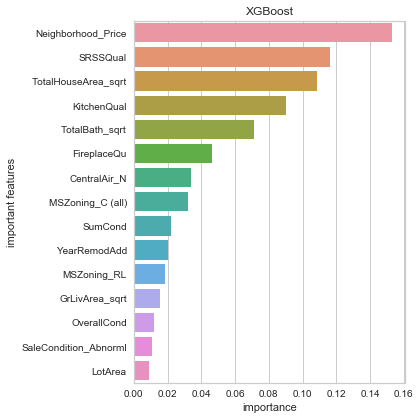

In [105]:
# Plotting xgb feature importances 

fig = plt.figure(figsize=(6, 6)) # (width,height)

ax = plt.subplot(1,1,1)
xgb_fi_plt = xgb_fi[:15]

sns.set_color_codes("pastel")
sns.barplot(x="importance", y="feature", data=xgb_fi_plt)
ax.set(ylabel='important features')
ax.set_title('XGBoost');

plt.tight_layout()

In [106]:
print(sum(xgb_fi['importance'][:10]))
print(sum(xgb_fi['importance'][:45]))

0.694022461771965
0.9196699541062117


The three most important features for the XGBoost model are engineered features. The most important feature is 'Neighborhood_Price', a ranked categorization of neighborhoods by sale price, which contributes 15% towards the decisions of the model. The average summed quality of a house ('SRSSQual') and the total house square footage ('TotalHouseArea') each account for ~10% of the model's predictive ability.

In total, the top 10 features make up ~70% of the feature importances. And 90% of the feature importances are contributed by the top 45 features. Since there are only 84 features total selected by the model, to generalize more I could probably even further reduce the number of features XGBoost is trained on.

## 8.5 XGBoost: Making predictions <a id='section_8.5'></a>

In [107]:
# Saving the XGBoost predictions for the test data
y_test_xgb = np.expm1(xgb_clf.predict(X_test_clean))
output = pd.DataFrame({'Id': X_test.index, 
                       'SalePrice': y_test_xgb})
output.to_csv('./output/submission_xgb.csv', index=False)

# 9. Model ensembling and final results <a id='section_9'></a>
[9.1 Combining Lasso, Ridge, XGBoost predictions](#section_9.1)  
[9.2 Comparing SalePrice predictions](#section_9.2)  
[9.3 Interpreting the final results](#section_9.3)  

## 9.1 Combining Lasso, Ridge, XGBoost predictions <a id='section_9.1'></a>
To combine the models, I'll take a weighted average of the predictions from all three models. 

In [108]:
# Combining the predictions from the training data set

y_predicted_combined = (0.4*y_predicted_lasso) + (0.1*y_predicted_ridge) + (0.5*y_predicted_xgb)
residuals_combined_dollars = np.expm1(y_clean)-np.expm1(y_predicted_combined)

In [109]:
# Combining the predictions for the test data set

y_test_combined = (0.4*y_test_lasso)+(0.1*y_test_lasso)+(0.5*y_test_xgb)
output = pd.DataFrame({'Id': X_test.index, 
                       'SalePrice': y_test_combined})
output.to_csv('./output/submission_combined.csv', index=False)

## 9.2 Comparing SalePrice predictions  <a id='section_9.2'></a>

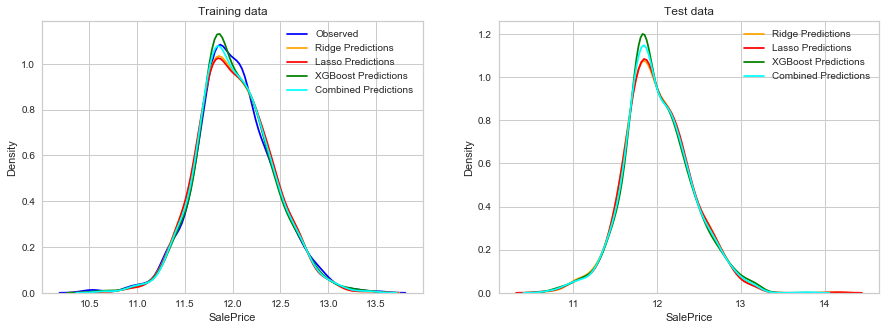

In [110]:
fig = plt.figure(figsize=(15, 5)) # (width,height)

# Density plot of the predictions for the training set
plt.subplot(1,2,1)

sns.kdeplot(y_clean, label = 'Observed', color='blue')
sns.kdeplot(y_predicted_ridge, label = 'Ridge Predictions', color='orange')
sns.kdeplot(y_predicted_lasso, label = 'Lasso Predictions', color='red')
sns.kdeplot(y_predicted_xgb, label = 'XGBoost Predictions', color='green')
sns.kdeplot(y_predicted_combined, label = 'Combined Predictions', color='cyan')
plt.title('Training data')
plt.xlabel('SalePrice')
plt.ylabel('Density');

# Density plot of the predictions for the test set
plt.subplot(1,2,2)

sns.kdeplot(np.log1p(y_test_ridge), label = 'Ridge Predictions', color='orange')
sns.kdeplot(np.log1p(y_test_lasso), label = 'Lasso Predictions', color='red')
sns.kdeplot(np.log1p(y_test_xgb), label = 'XGBoost Predictions', color='green')
sns.kdeplot(np.log1p(y_test_combined), label = 'Combined Predictions', color='cyan')
plt.title('Test data')
plt.xlabel('SalePrice')
plt.ylabel('Density');

Lasso and Ridge have nearly identical predictions on the training set and test set. The predictions of XGBoost have a slightly more strongly peaked central distribution as compared to the linear models.

## 9.3 Interpreting the final results <a id='section_9.3'></a>
The average RMSE of the models is ~0.11. But what does this mean in terms of dollars?

### Distribution of residuals

count      1458.000000
mean        994.913078
std       14438.525023
min     -104624.648554
25%       -6307.132245
50%         341.975109
75%        7353.733839
max      115037.841903
Name: SalePrice, dtype: float64


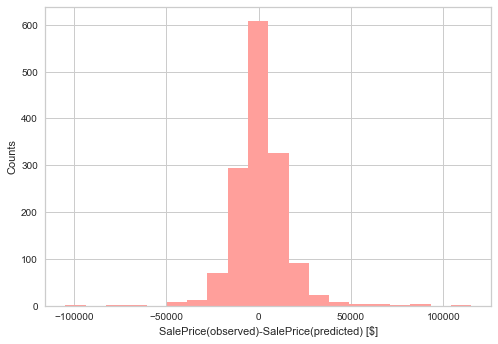

In [111]:
# Histogram of residuals

print(residuals_combined_dollars.describe())

ax = plt.subplot(1,1,1)
plt.hist(residuals_combined_dollars, 20, color='r')
plt.xlabel('SalePrice(observed)-SalePrice(predicted) [$]')
plt.ylabel('Counts');

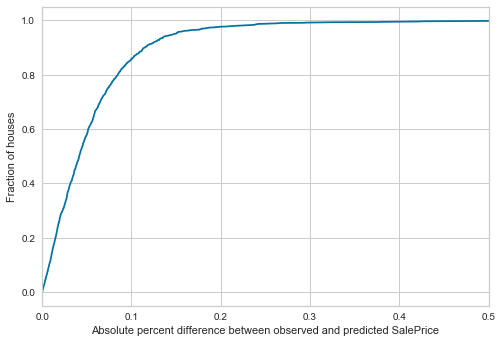

In [112]:
# CDF of residuals

cdf_x = np.sort(np.abs(residuals_combined_dollars)/np.expm1(y_clean))
cdf_y = np.arange(len(cdf_x))/len(cdf_x)
plt.xlim(0,0.5)
plt.plot(cdf_x,cdf_y)
plt.xlabel('Absolute percent difference between observed and predicted SalePrice')
plt.ylabel('Fraction of houses');

In [113]:
ind=np.where(np.abs(cdf_x-0.1)==min(np.abs(cdf_x-0.1)))[0][0]
cdf_y[ind]

0.8573388203017832

For 85% of houses, my model is able to predict the sale price to within 10% of the actual value.

### Comparing feature importances

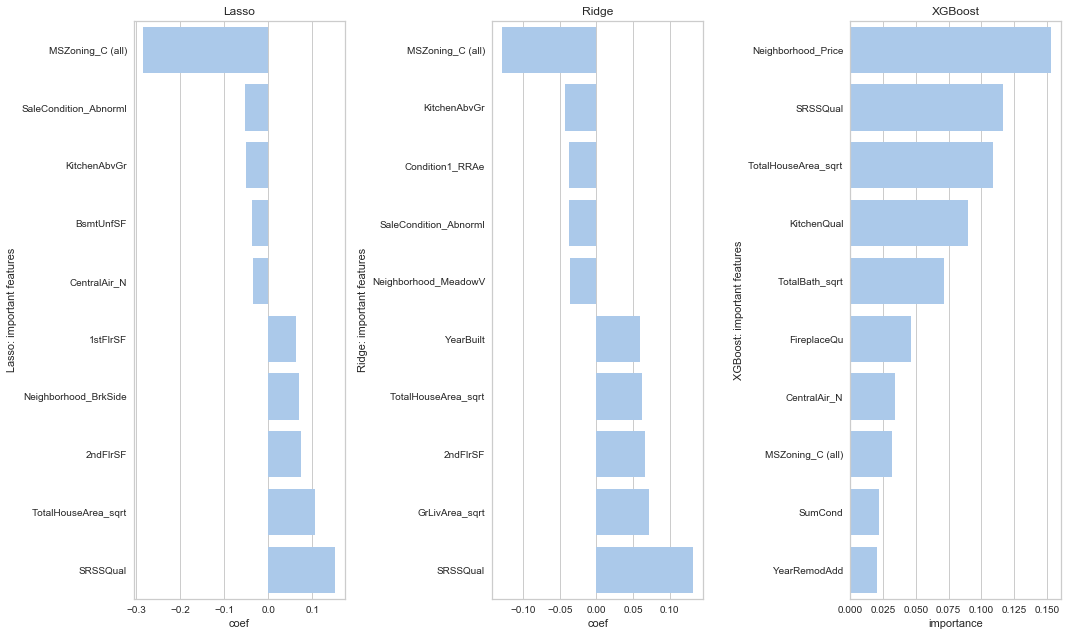

In [114]:
# Plotting lasso feature importances 

fig = plt.figure(figsize=(15, 9)) # (width,height)

'''
Lasso coefficients
'''
ax = plt.subplot(1,3,1)
coef_plt = pd.concat([lasso_coef[:5], lasso_coef[-5:]],axis=0)

sns.set_color_codes("pastel")
sns.barplot(x="coef", y="features", data=coef_plt, color='b')
ax.set(ylabel='Lasso: important features')
ax.set_title('Lasso');

'''
Ridge coefficients
'''
ax = plt.subplot(1,3,2)
coef_plt = pd.concat([ridge_coef[:5], ridge_coef[-5:]],axis=0)
sns.barplot(x="coef", y="features", data=coef_plt, color='b')
ax.set(ylabel='Ridge: important features')
ax.set_title('Ridge');

'''
XGBoost feature importances
'''
ax = plt.subplot(1,3,3)
xgb_fi_plt = xgb_fi[:10]
sns.barplot(x="importance", y="feature", data=xgb_fi_plt, color='b')
ax.set(ylabel='XGBoost: important features')
ax.set_title('XGBoost');

plt.tight_layout()
#plt.subplots_adjust(wspace=0.5)

Common important features to all three models are the quality of the house ('SRSSQual'), the total square footage of the house ('TotalHouseArea'), whether the house has central air conditioning ('CentralAir'), and whether the house is in a commercial zone ('MSZoning_C(all)').

In general, it seems that factors important for determining the sale price of a house include the location, the size of the house, and the quality of the house.

# Useful References
Some resources I found to be especially helpful throughout working on this project:

General machine learning references:
- "Introduction to Machine Learning with Python: A Guide for Data Scientists" - Andreas C. Müller and Sarah Guido
- [Kaggle Tutorials](https://www.kaggle.com/learn/overview)
- [Will Koehrsen's "A Complete Machine Learning Project Walk-Through in Python" series](https://towardsdatascience.com/a-complete-machine-learning-walk-through-in-python-part-one-c62152f39420)  


Kernels specific to the Kaggle Ames Housing problem:
- https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
- https://medium.com/diogo-menezes-borges/project-2-predicting-house-prices-on-kaggle-989f1b0c4ef6